In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import pearsonr, spearmanr

In [2]:
train_df = pd.read_csv('C:/Users/Olidia Lunga/Desktop/Data Science/Hotel/train.csv', nrows = 100000)
train_df.head()

,date_time,site_name,posa_continent,user_location_country,user_location_region,user_location_city,orig_destination_distance,user_id,is_mobile,is_package,...,srch_children_cnt,srch_rm_cnt,srch_destination_id,srch_destination_type_id,is_booking,cnt,hotel_continent,hotel_country,hotel_market,hotel_cluster
0,2014-08-11 07:46:59,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,0,3,2,50,628,1
1,2014-08-11 08:22:12,2,3,66,348,48862,2234.2641,12,0,1,...,0,1,8250,1,1,1,2,50,628,1
2,2014-08-11 08:24:33,2,3,66,348,48862,2234.2641,12,0,0,...,0,1,8250,1,0,1,2,50,628,1
3,2014-08-09 18:05:16,2,3,66,442,35390,913.1932,93,0,0,...,0,1,14984,1,0,1,2,50,1457,80
4,2014-08-09 18:08:18,2,3,66,442,35390,913.6259,93,0,0,...,0,1,14984,1,0,1,2,50,1457,21


In [3]:
# Display the shape of the loaded datasets
print(f"Train shape: {train_df.shape}")

Train shape: (100000, 24)


In [4]:
train_df.describe(include=['O'])

,date_time,srch_ci,srch_co
count,100000,99929,99929
unique,99840,1029,1034
top,2014-04-10 13:57:24,2014-12-26,2015-01-02
freq,3,714,659


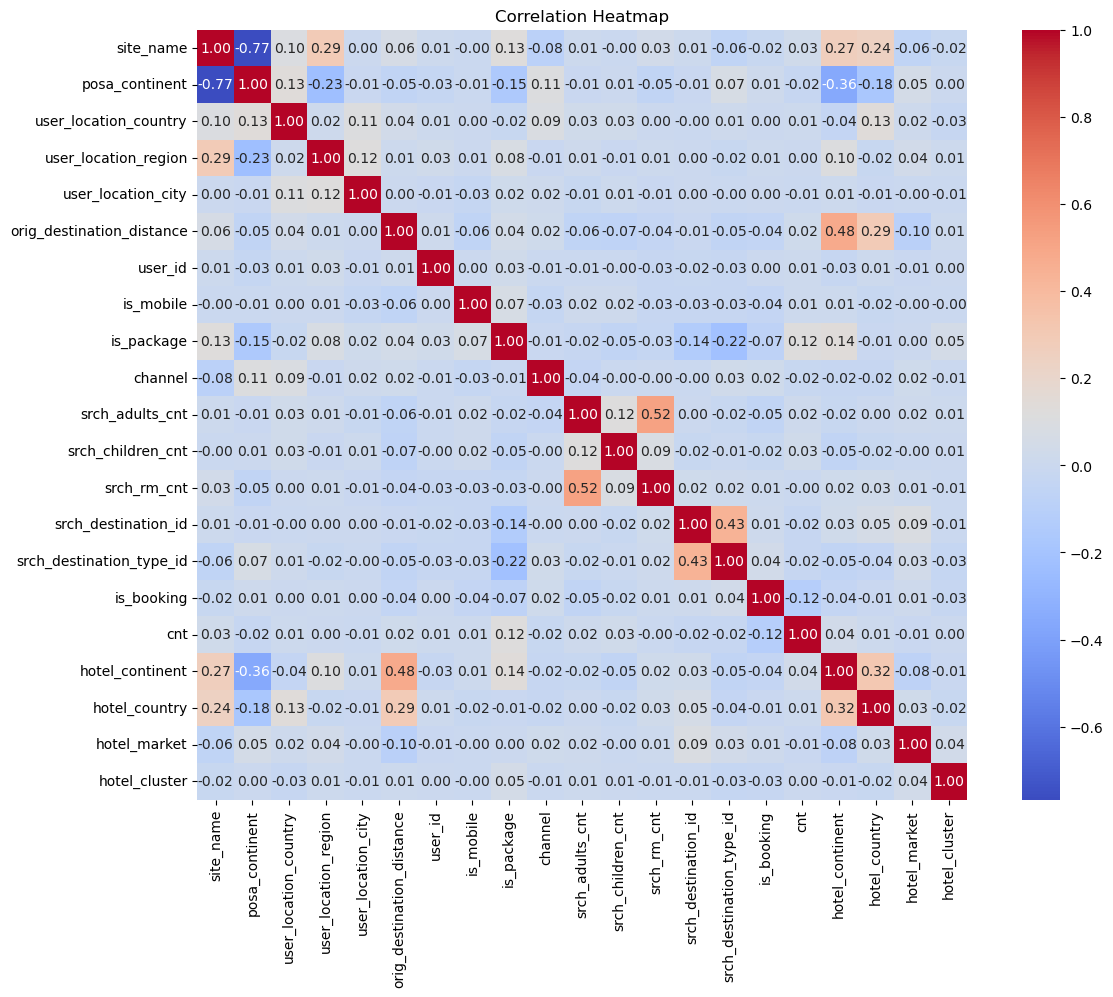

         Feature 1        Feature 2  Correlation
0   posa_continent        site_name    -0.767217
1        site_name   posa_continent    -0.767217
2      srch_rm_cnt  srch_adults_cnt     0.520605
3  srch_adults_cnt      srch_rm_cnt     0.520605
Strong correlations with hotel_cluster:
hotel_cluster    1.0
Name: hotel_cluster, dtype: float64


In [7]:
# Select only numeric columns
train_df_numeric = train_df.select_dtypes(include=['int64', 'float64'])

# Calculate the correlation matrix
correlation_matrix = train_df_numeric.corr()

# Plotting the correlation heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Correlation Heatmap')
plt.show()

# Set a threshold for high correlation
threshold = 0.5

# Create a DataFrame to hold pairs of features with high correlations
high_correlations = []

# Loop through the correlation matrix
for col in correlation_matrix.columns:
    for row in correlation_matrix.index:
        if (correlation_matrix.loc[row, col] > threshold or correlation_matrix.loc[row, col] < -threshold) and row != col:
            high_correlations.append((row, col, correlation_matrix.loc[row, col]))

# Convert the list to a DataFrame for better readability
high_correlations_df = pd.DataFrame(high_correlations, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Display the high correlations
print(high_correlations_df)

# Identify strong correlations with hotel_cluster
if 'hotel_cluster' in train_df_numeric.columns:
    strong_correlations = correlation_matrix[abs(correlation_matrix['hotel_cluster']) > threshold]['hotel_cluster']
    print("Strong correlations with hotel_cluster:")
    print(strong_correlations)
else:
    print("hotel_cluster not found in the numeric DataFrame.")

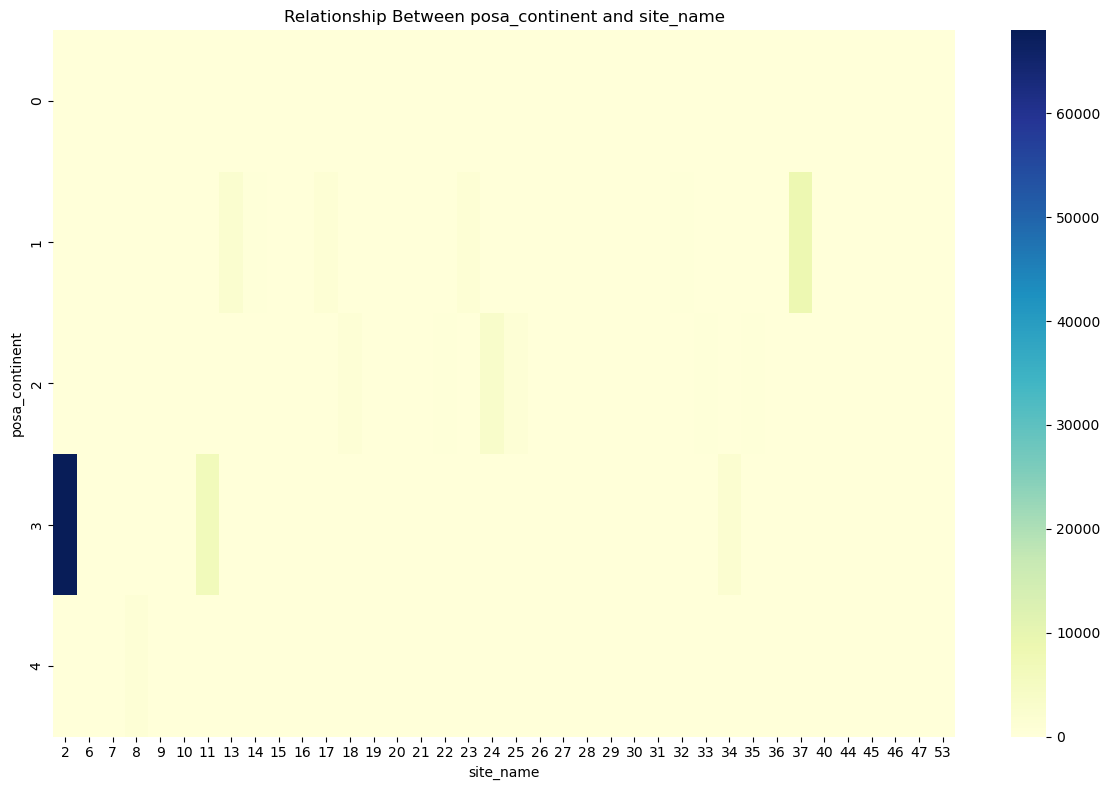

In [8]:
#Analyze the relationship between posa_continent and site_name
plt.figure(figsize=(12, 8))
cross_tab = pd.crosstab(train_df['posa_continent'], train_df['site_name'])
sns.heatmap(cross_tab, cmap='YlGnBu', annot=False)
plt.title('Relationship Between posa_continent and site_name')
plt.xlabel('site_name')
plt.ylabel('posa_continent')
plt.tight_layout()
plt.show()

In [9]:
# Chi-square test of independence
chi2, p, dof, expected = chi2_contingency(cross_tab)

print(f"Chi-square statistic: {chi2}")
print(f"p-value: {p}")
print(f"Degrees of freedom: {dof}")

# Interpret the results
alpha = 0.05
if p < alpha:
    print("There is a statistically significant relationship between posa_continent and site_name")
    print(f"We can reject the null hypothesis of independence with p-value = {p:.10f}")
else:
    print("There is not enough evidence to suggest a relationship between posa_continent and site_name")
    
# Calculate Cramer's V to measure the strength of association
n = cross_tab.sum().sum()
phi2 = chi2/n
r, k = cross_tab.shape
phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
r_corr = r - ((r-1)**2)/(n-1)
k_corr = k - ((k-1)**2)/(n-1)
cramers_v = np.sqrt(phi2corr / min((k_corr-1), (r_corr-1)))
print(f"Cramer's V: {cramers_v:.4f} (0 = no association, 1 = perfect association)")

Chi-square statistic: 400000.0
p-value: 0.0
Degrees of freedom: 148
There is a statistically significant relationship between posa_continent and site_name
We can reject the null hypothesis of independence with p-value = 0.0000000000
Cramer's V: 0.9998 (0 = no association, 1 = perfect association)


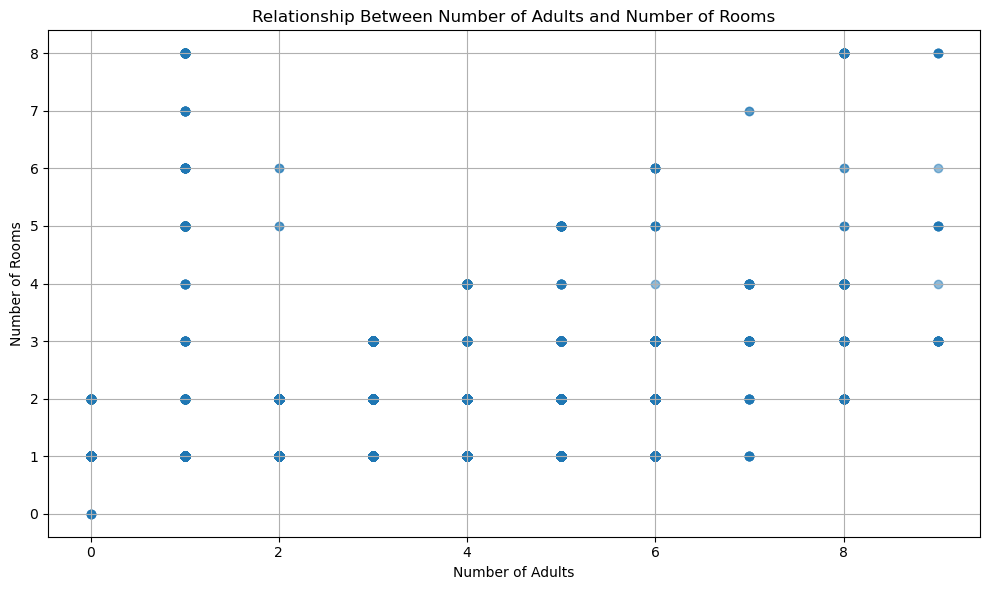

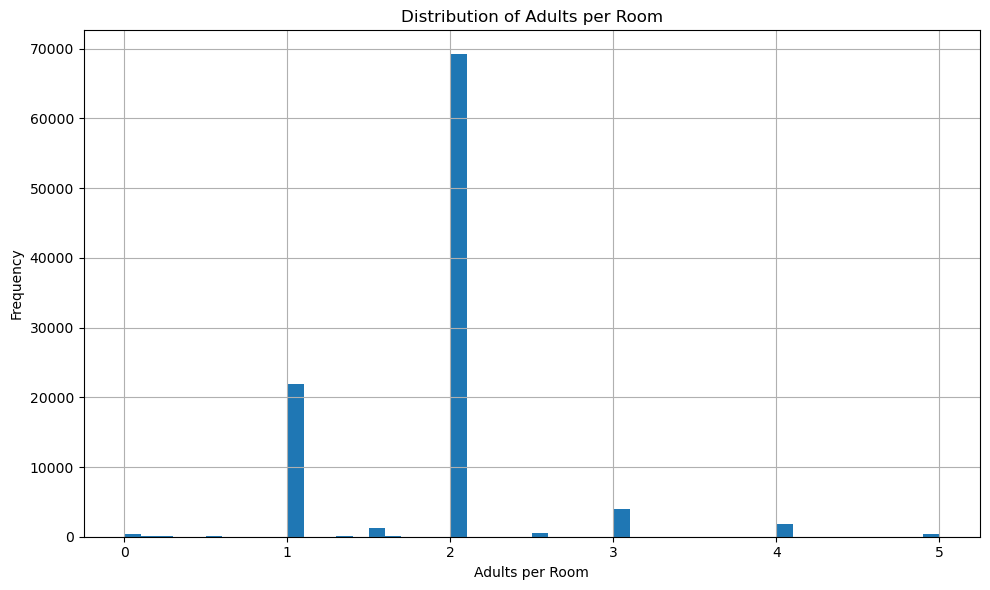

In [27]:
#Verify the correlation between srch_rm_cnt and srch_adults_cnt
plt.figure(figsize=(10, 6))
plt.scatter(train_df['srch_adults_cnt'], train_df['srch_rm_cnt'], alpha=0.5)
plt.title('Relationship Between Number of Adults and Number of Rooms')
plt.xlabel('Number of Adults')
plt.ylabel('Number of Rooms')
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the average number of adults per room
train_df['adults_per_room'] = train_df['srch_adults_cnt'] / train_df['srch_rm_cnt']
plt.figure(figsize=(10, 6))
plt.hist(train_df['adults_per_room'].clip(0, 5), bins=50)
plt.title('Distribution of Adults per Room')
plt.xlabel('Adults per Room')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
# Pearson correlation (parametric test)
pearson_corr, pearson_p = pearsonr(train_df['srch_adults_cnt'], train_df['srch_rm_cnt'])
print(f"Pearson correlation coefficient: {pearson_corr:.4f}")
print(f"Pearson p-value: {pearson_p:.10f}")

# Spearman rank correlation (non-parametric test)
spearman_corr, spearman_p = spearmanr(train_df['srch_adults_cnt'], train_df['srch_rm_cnt'])
print(f"Spearman correlation coefficient: {spearman_corr:.4f}")
print(f"Spearman p-value: {spearman_p:.10f}")

# Interpret the results
alpha = 0.05
if pearson_p < alpha and spearman_p < alpha:
    print("There is a statistically significant correlation between number of adults and number of rooms")
    if pearson_corr > 0:
        print("The correlation is positive, suggesting that as the number of adults increases, the number of rooms tends to increase")
    else:
        print("The correlation is negative, suggesting that as the number of adults increases, the number of rooms tends to decrease")
else:
    print("There is not enough evidence to suggest a correlation between number of adults and number of rooms")

# Calculate coefficient of determination (R²)
r_squared = pearson_corr**2
print(f"R²: {r_squared:.4f} ({r_squared*100:.1f}% of the variance in one variable is explained by the other)")

Pearson correlation coefficient: 0.5206
Pearson p-value: 0.0000000000
Spearman correlation coefficient: 0.4415
Spearman p-value: 0.0000000000
There is a statistically significant correlation between number of adults and number of rooms
The correlation is positive, suggesting that as the number of adults increases, the number of rooms tends to increase
R²: 0.2710 (27.1% of the variance in one variable is explained by the other)


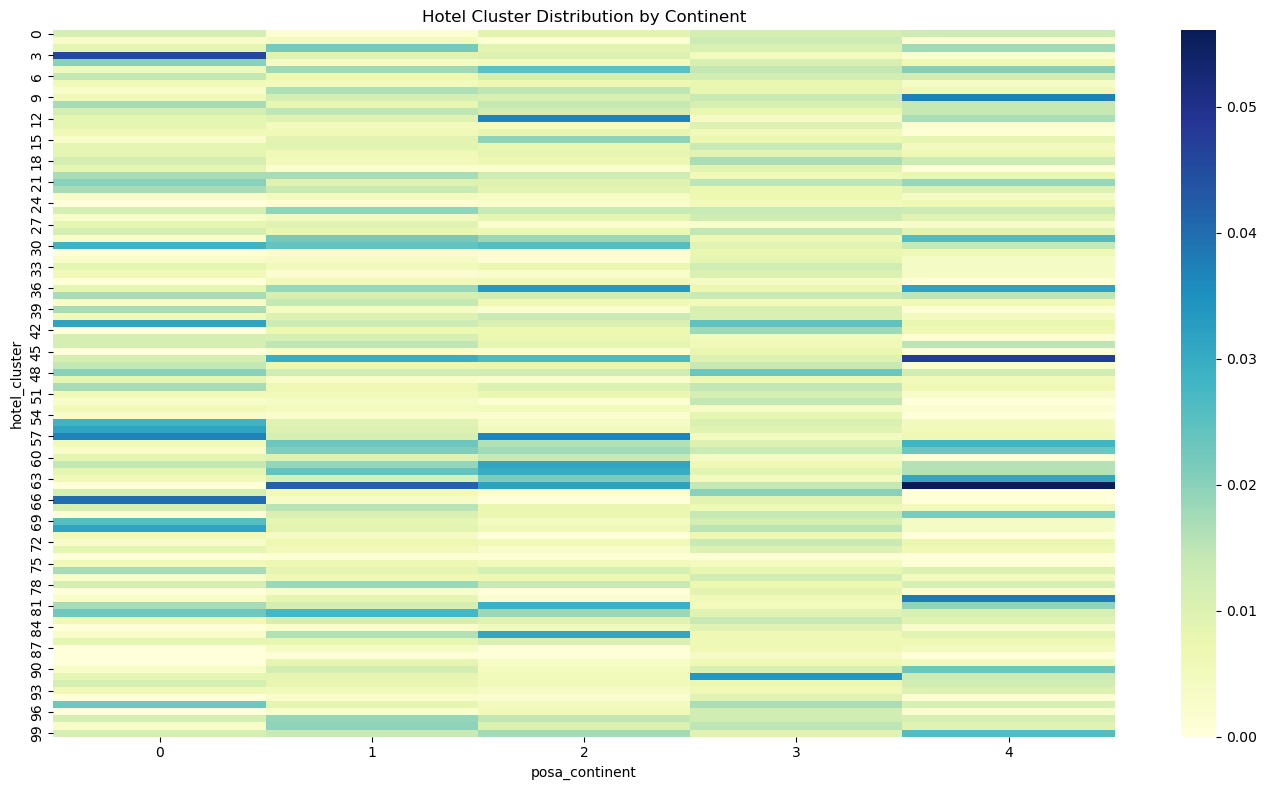

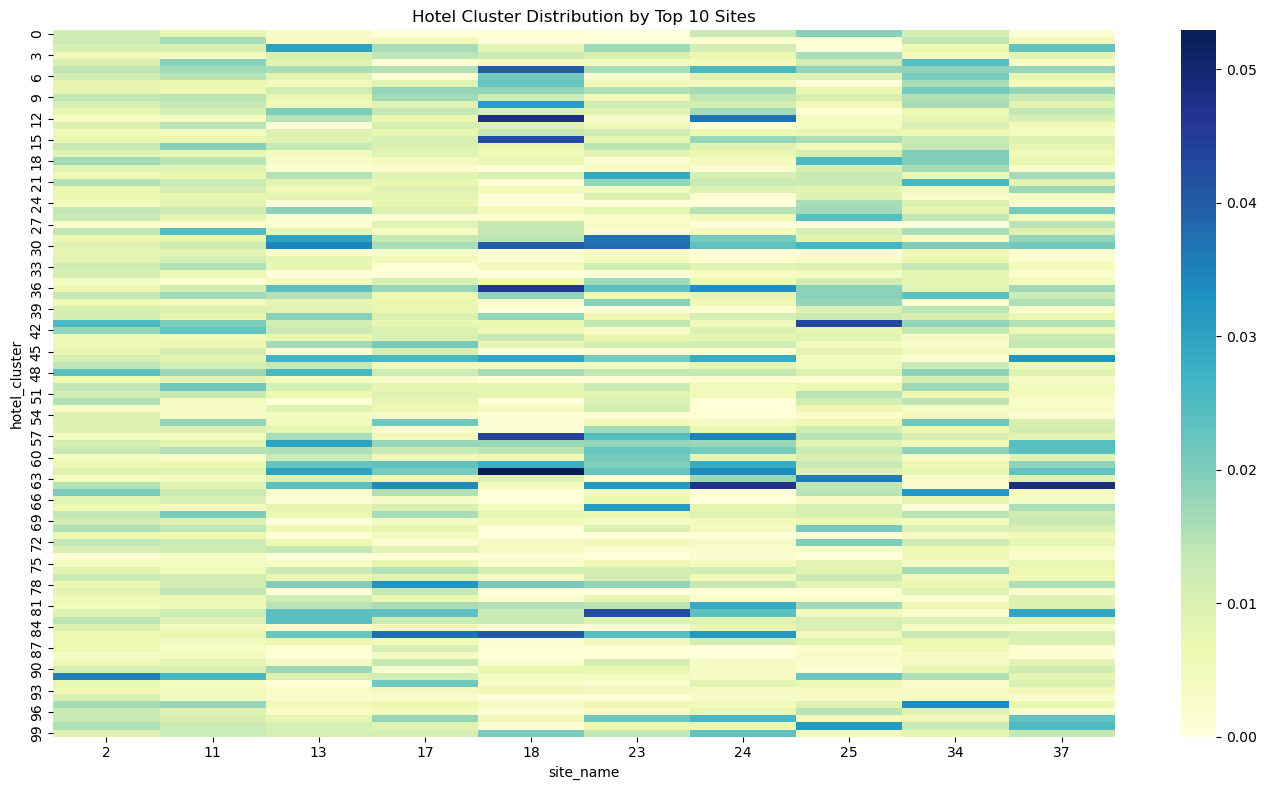

In [12]:
# 3. Examine how these correlated features relate to hotel_cluster
# First for posa_continent
plt.figure(figsize=(14, 8))
cluster_continent = pd.crosstab(train_df['hotel_cluster'], train_df['posa_continent'], normalize='columns')
sns.heatmap(cluster_continent, cmap='YlGnBu')
plt.title('Hotel Cluster Distribution by Continent')
plt.xlabel('posa_continent')
plt.ylabel('hotel_cluster')
plt.tight_layout()
plt.show()

# Then for site_name (top sites only for readability)
top_sites = train_df['site_name'].value_counts().head(10).index
site_subset = train_df[train_df['site_name'].isin(top_sites)]
plt.figure(figsize=(14, 8))
cluster_site = pd.crosstab(site_subset['hotel_cluster'], site_subset['site_name'], normalize='columns')
sns.heatmap(cluster_site, cmap='YlGnBu')
plt.title('Hotel Cluster Distribution by Top 10 Sites')
plt.xlabel('site_name')
plt.ylabel('hotel_cluster')
plt.tight_layout()
plt.show()

In [18]:
# Chi-square tests for independence between hotel_cluster and these features
for feature in ['posa_continent', 'site_name']:
    contingency = pd.crosstab(train_df['hotel_cluster'], train_df[feature])
    chi2, p, dof, expected = chi2_contingency(contingency)
    print(f"\nChi-square test for hotel_cluster and {feature}:")
    print(f"Chi-square statistic: {chi2}")
    print(f"p-value: {p}")
    
    # Effect size with Cramer's V
    n = contingency.sum().sum()
    phi2 = chi2/n
    r, k = contingency.shape
    cramers_v = np.sqrt(phi2 / min(k-1, r-1))
    print(f"Cramer's V: {cramers_v:.4f}")
    
    # Hypothesis conclusion
    if p < 0.05:
        print(f"We reject the null hypothesis. There is a significant association between hotel_cluster and {feature}.")
    else:
        print(f"We fail to reject the null hypothesis. There is no significant association between hotel_cluster and {feature}.")

# Cramer's V
    print(f"Cramer's V: {cramers_v:.4f}")
    
    # Effect size interpretation
    if cramers_v < 0.1:
        effect_size = "small effect"
    elif cramers_v < 0.3:
        effect_size = "medium effect"
    else:
        effect_size = "large effect"

    print(f"The strength of the association is a {effect_size} (Cramer's V).")


Chi-square test for hotel_cluster and posa_continent:
Chi-square statistic: 14543.039791386873
p-value: 0.0
Cramer's V: 0.1907
We reject the null hypothesis. There is a significant association between hotel_cluster and posa_continent.
Cramer's V: 0.1907
The strength of the association is a medium effect (Cramer's V).

Chi-square test for hotel_cluster and site_name:
Chi-square statistic: 28417.375394715687
p-value: 0.0
Cramer's V: 0.0876
We reject the null hypothesis. There is a significant association between hotel_cluster and site_name.
Cramer's V: 0.0876
The strength of the association is a small effect (Cramer's V).


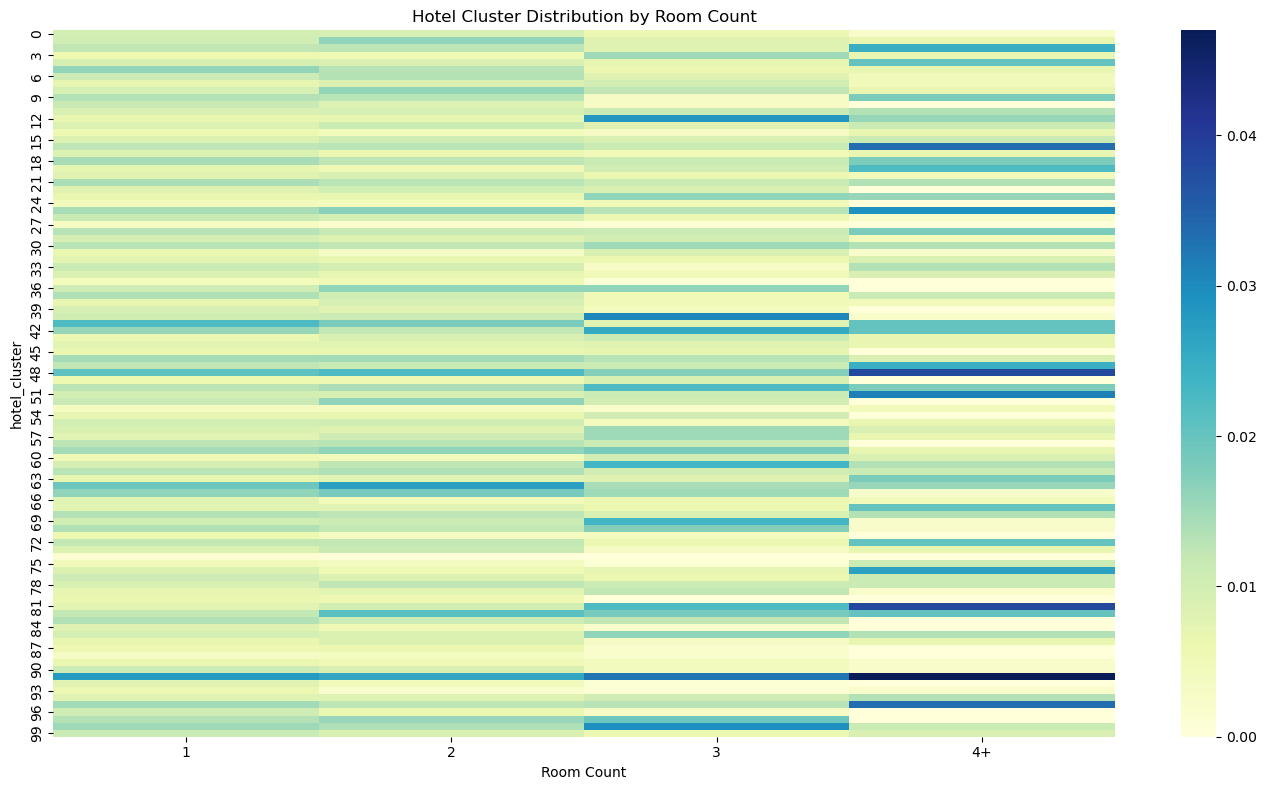

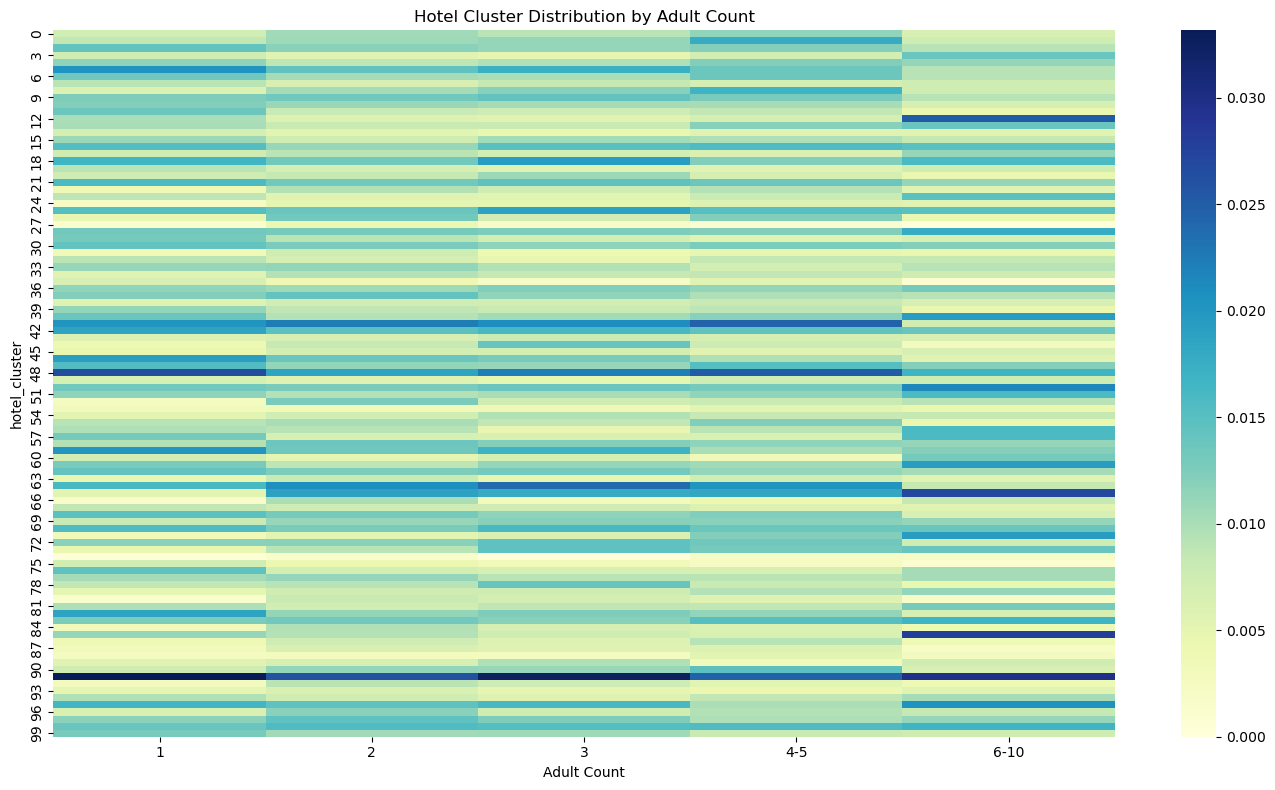

In [19]:
# 4. Analyze how srch_rm_cnt and srch_adults_cnt relate to hotel_cluster

# Create room and adult categories for easier visualization
train_df['room_category'] = pd.cut(train_df['srch_rm_cnt'], bins=[0, 1, 2, 3, 10], labels=['1', '2', '3', '4+'])
train_df['adult_category'] = pd.cut(train_df['srch_adults_cnt'], bins=[0, 1, 2, 3, 5, 10, 100], 
                                    labels=['1', '2', '3', '4-5', '6-10', '10+'])

# Room count vs hotel cluster
plt.figure(figsize=(14, 8))
room_cluster = pd.crosstab(train_df['hotel_cluster'], train_df['room_category'], normalize='columns')
sns.heatmap(room_cluster, cmap='YlGnBu')
plt.title('Hotel Cluster Distribution by Room Count')
plt.xlabel('Room Count')
plt.ylabel('hotel_cluster')
plt.tight_layout()
plt.show()

# Adult count vs hotel cluster
plt.figure(figsize=(14, 8))
adult_cluster = pd.crosstab(train_df['hotel_cluster'], train_df['adult_category'], normalize='columns')
sns.heatmap(adult_cluster, cmap='YlGnBu')
plt.title('Hotel Cluster Distribution by Adult Count')
plt.xlabel('Adult Count')
plt.ylabel('hotel_cluster')
plt.tight_layout()
plt.show()

In [21]:
# ANOVA test to see if hotel clusters differ in their mean room counts
from scipy.stats import f_oneway

# Group by hotel cluster and get room counts for each
room_groups = [train_df.loc[train_df['hotel_cluster'] == cluster, 'srch_rm_cnt'] 
               for cluster in train_df['hotel_cluster'].unique()]

# Run ANOVA
f_stat, p_value = f_oneway(*room_groups)
print("\nANOVA test for room counts across hotel clusters:")
print(f"F-statistic: {f_stat}")
print(f"p-value: {p_value}")

# Hypothesis conclusion for room counts
if p_value < 0.05:
    print("We reject the null hypothesis. There is a significant difference in mean room counts across hotel clusters.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference in mean room counts across hotel clusters.")

# Repeat for adult counts
adult_groups = [train_df.loc[train_df['hotel_cluster'] == cluster, 'srch_adults_cnt'] 
                for cluster in train_df['hotel_cluster'].unique()]
f_stat, p_value = f_oneway(*adult_groups)
print("\nANOVA test for adult counts across hotel clusters:")
print(f"F-statistic: {f_stat}")
print(f"p-value: {p_value}")

# Hypothesis conclusion for adult counts
if p_value < 0.05:
    print("We reject the null hypothesis. There is a significant difference in mean adult counts across hotel clusters.")
else:
    print("We fail to reject the null hypothesis. There is no significant difference in mean adult counts across hotel clusters.")


ANOVA test for room counts across hotel clusters:
F-statistic: 4.73822558486241
p-value: 2.5563147049524492e-49
We reject the null hypothesis. There is a significant difference in mean room counts across hotel clusters.

ANOVA test for adult counts across hotel clusters:
F-statistic: 8.716828374355847
p-value: 1.4216530656510272e-121
We reject the null hypothesis. There is a significant difference in mean adult counts across hotel clusters.


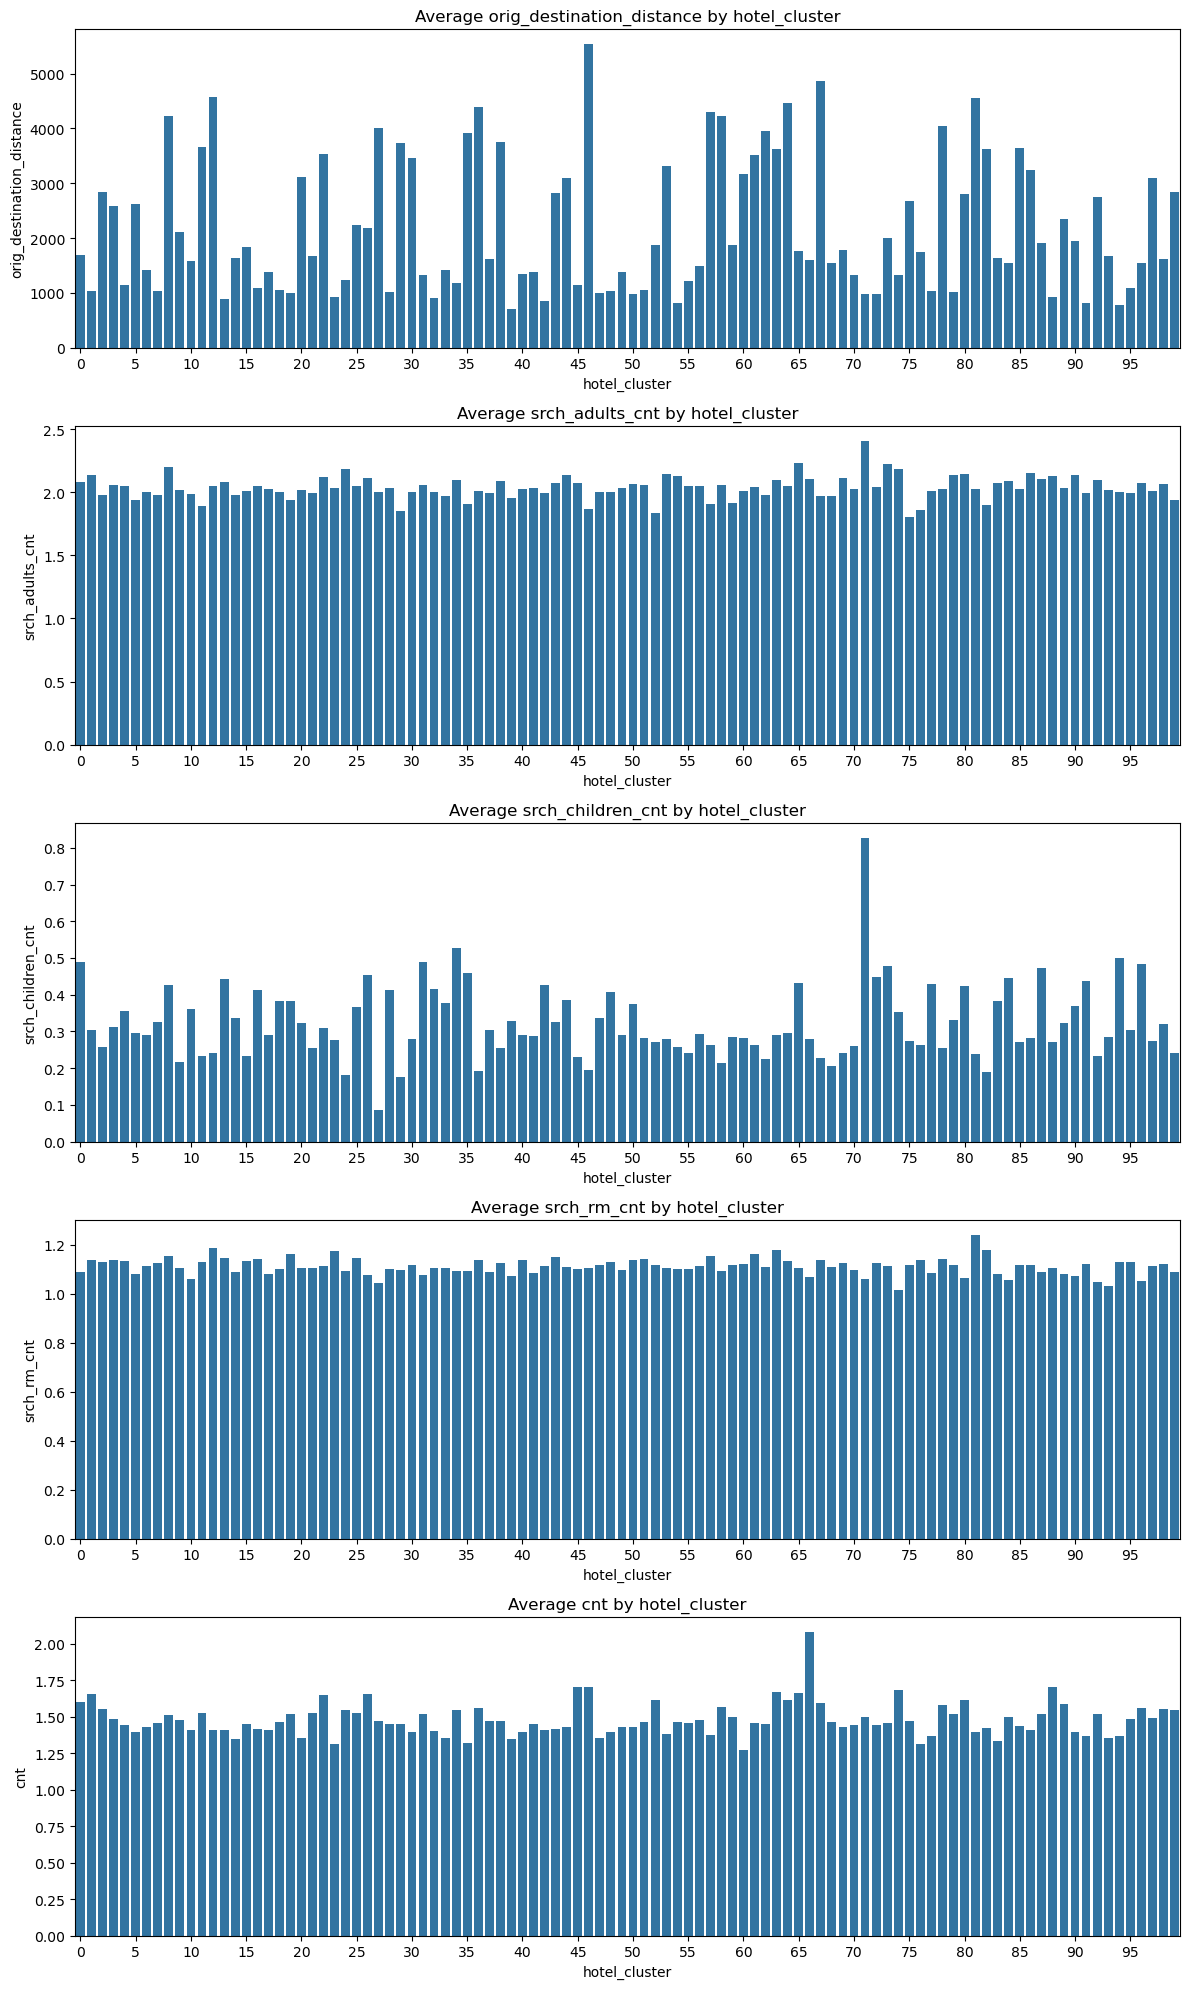

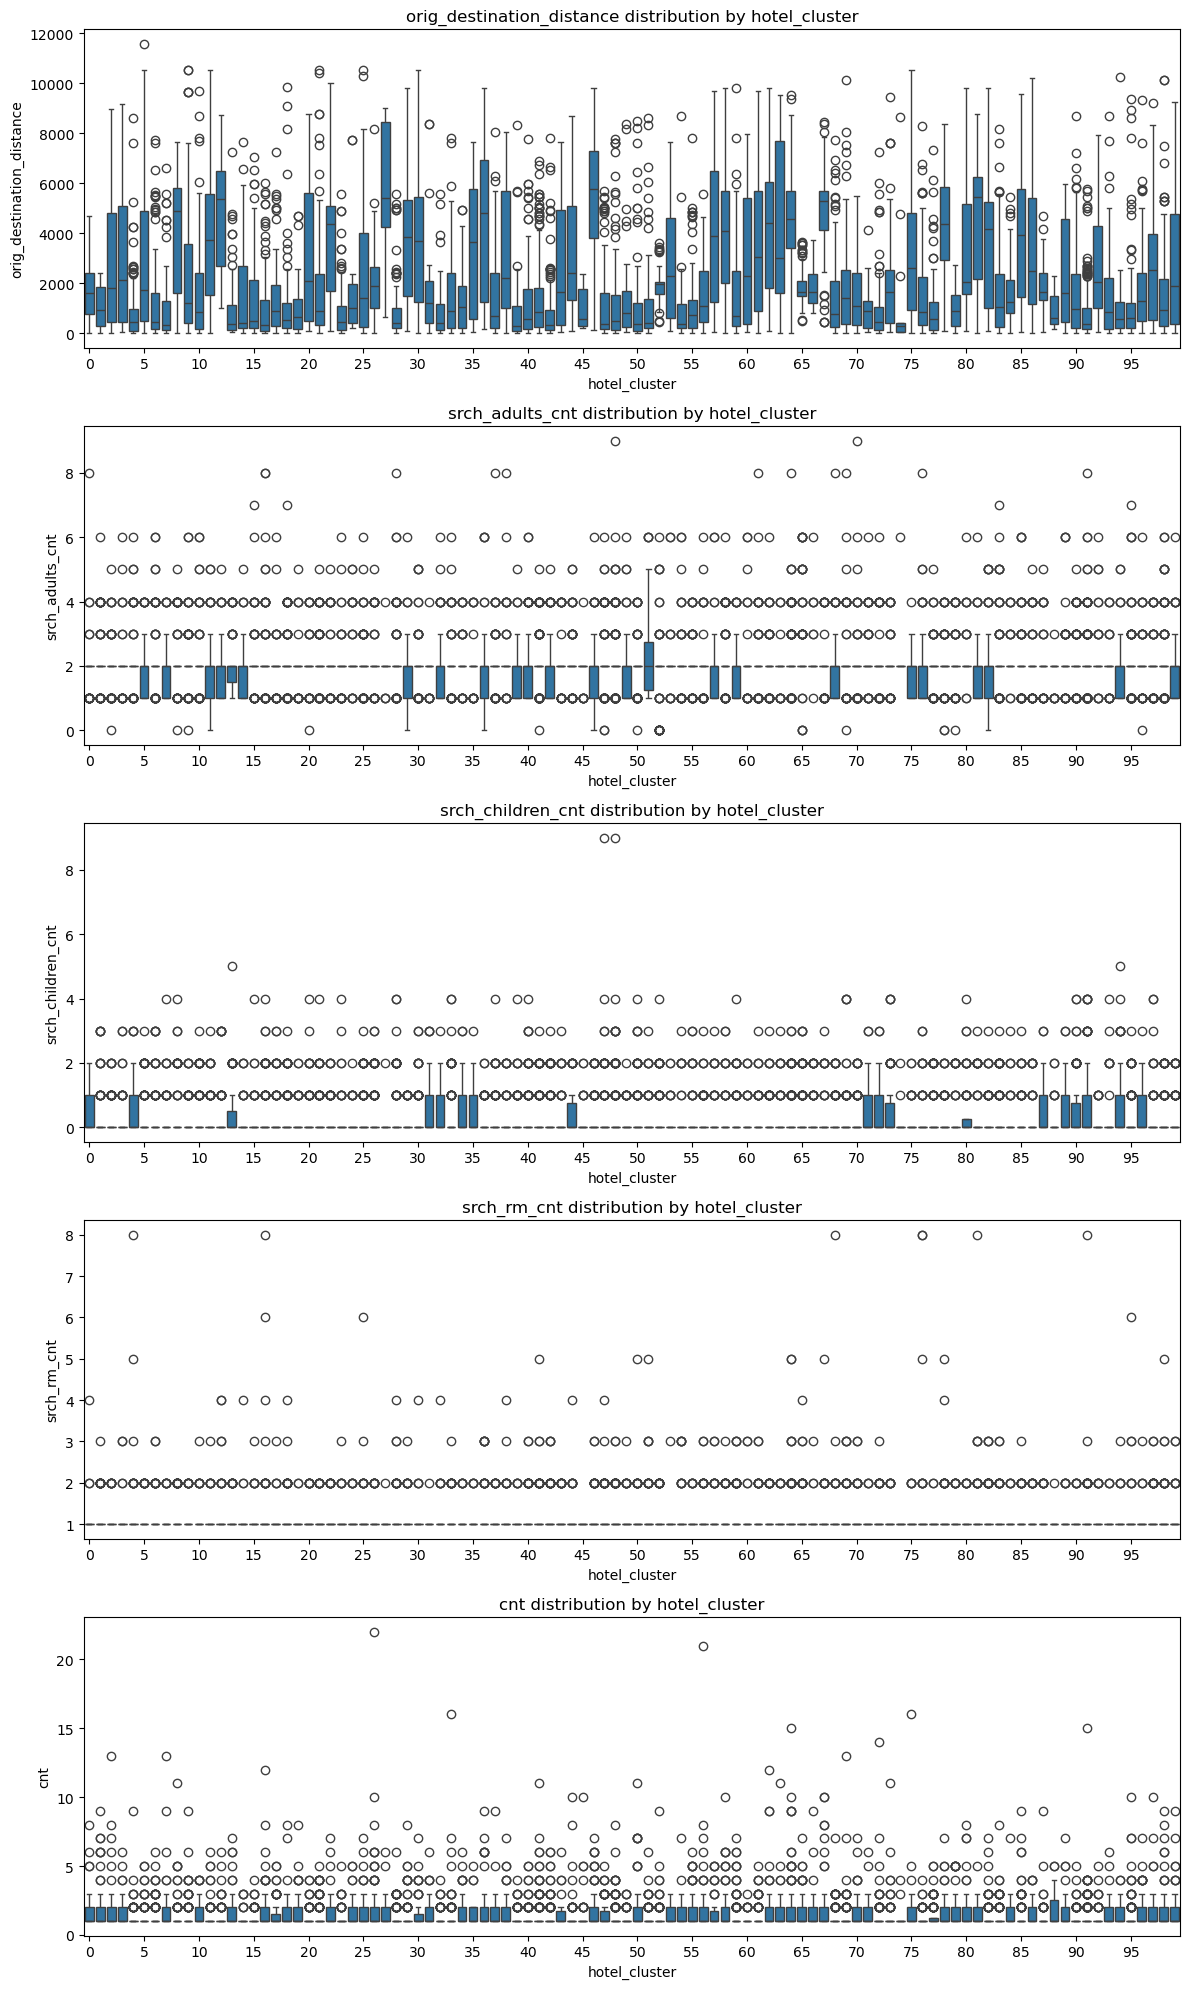

In [22]:
#Non-linear relationships with hotel_cluster

# For numerical features against hotel_cluster
numerical_features = ['orig_destination_distance', 'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'cnt']

fig, axes = plt.subplots(len(numerical_features), 1, figsize=(12, 4*len(numerical_features)))

for i, feature in enumerate(numerical_features):
    # Handle potential NaN values in orig_destination_distance
    if feature == 'orig_destination_distance':
        valid_data = train_df[~train_df[feature].isna()]
    else:
        valid_data = train_df
    
    # For each hotel_cluster, compute the mean value of the feature
    cluster_means = valid_data.groupby('hotel_cluster')[feature].mean().reset_index()
    
    # Sort by hotel_cluster for better visualization
    cluster_means = cluster_means.sort_values('hotel_cluster')
    
    # Plot
    sns.barplot(x='hotel_cluster', y=feature, data=cluster_means, ax=axes[i])
    axes[i].set_title(f'Average {feature} by hotel_cluster')
    
    # If there are too many clusters, limit the displayed ticks
    if len(cluster_means['hotel_cluster'].unique()) > 20:
        axes[i].set_xticks(axes[i].get_xticks()[::5])  # Show every 5th tick

plt.tight_layout()
plt.show()

# Create box plots to see the distribution
fig, axes = plt.subplots(len(numerical_features), 1, figsize=(12, 4*len(numerical_features)))

for i, feature in enumerate(numerical_features):
    if feature == 'orig_destination_distance':
        valid_data = train_df[~train_df[feature].isna()]
    else:
        valid_data = train_df
    
    # Sample data if it's too large
    if len(valid_data) > 10000:
        valid_data = valid_data.sample(10000, random_state=42)
    
    # Plot
    sns.boxplot(x='hotel_cluster', y=feature, data=valid_data, ax=axes[i])
    axes[i].set_title(f'{feature} distribution by hotel_cluster')
    
    # Limit ticks if needed
    if len(valid_data['hotel_cluster'].unique()) > 20:
        axes[i].set_xticks(axes[i].get_xticks()[::5])

plt.tight_layout()
plt.show()


Analyzing site_name:
site_name has 38 unique values. Analyzing top 10 most common values.


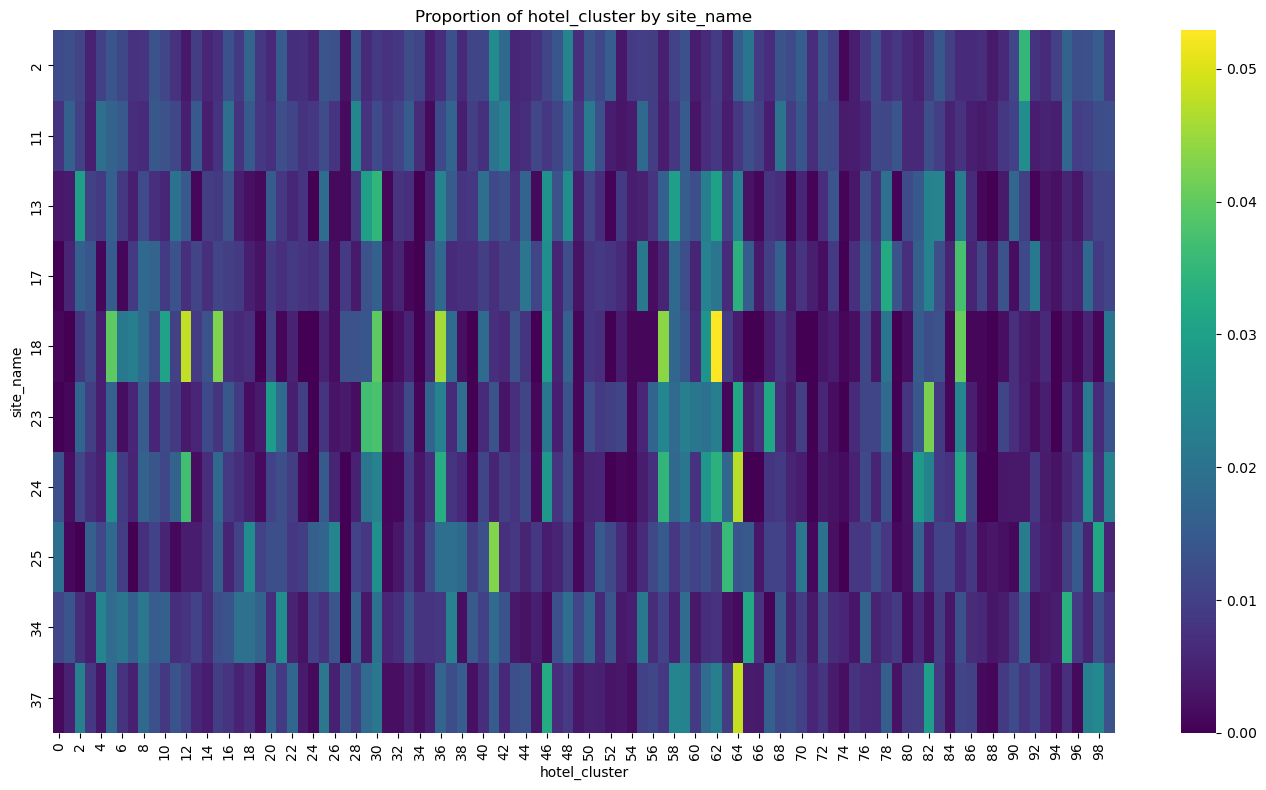

2: [(91, 2384), (41, 1720), (48, 1623)]
11: [(91, 172), (28, 163), (42, 151)]
13: [(30, 78), (62, 68), (2, 67)]
17: [(85, 42), (64, 38), (78, 36)]
18: [(62, 52), (12, 47), (36, 45)]
...

Analyzing posa_continent:


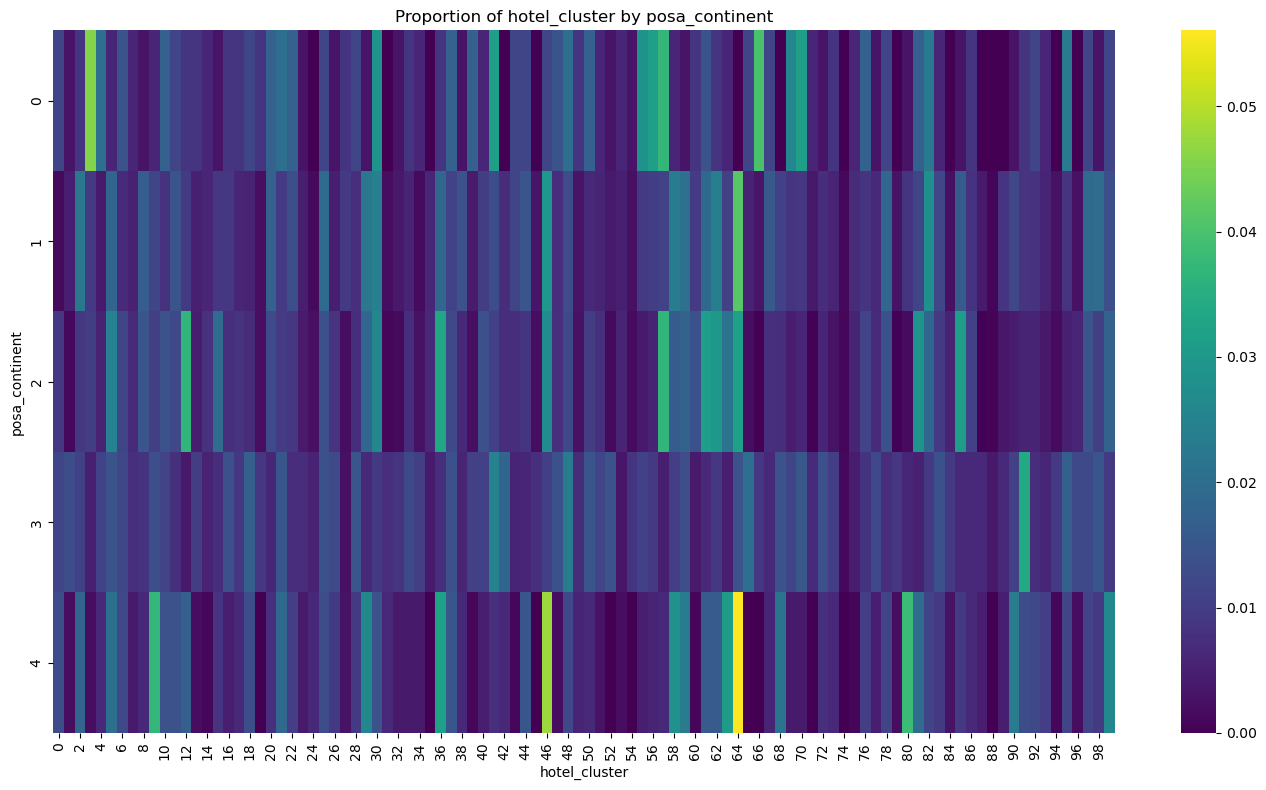

0: [(3, 16), (66, 14), (57, 13)]
1: [(64, 600), (46, 430), (82, 402)]
2: [(57, 264), (12, 263), (36, 240)]
3: [(91, 2598), (41, 1891), (48, 1785)]
4: [(64, 60), (46, 51), (80, 41)]

Analyzing user_location_country:
user_location_country has 123 unique values. Analyzing top 10 most common values.


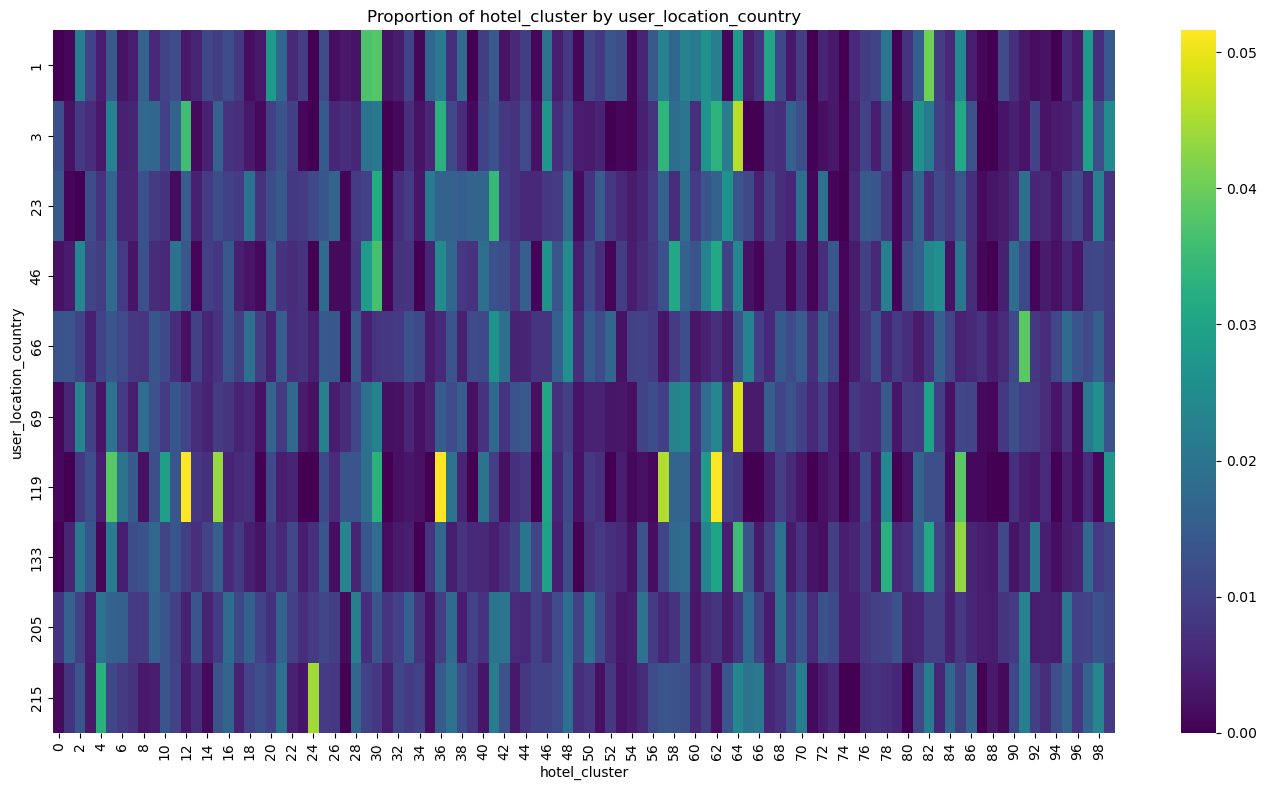

1: [(82, 48), (30, 45), (29, 44)]
3: [(64, 164), (12, 127), (57, 119)]
23: [(41, 46), (30, 42), (63, 35)]
46: [(30, 80), (58, 68), (62, 68)]
66: [(91, 2282), (41, 1546), (48, 1506)]
...

Analyzing user_location_region:
user_location_region has 510 unique values. Analyzing top 10 most common values.


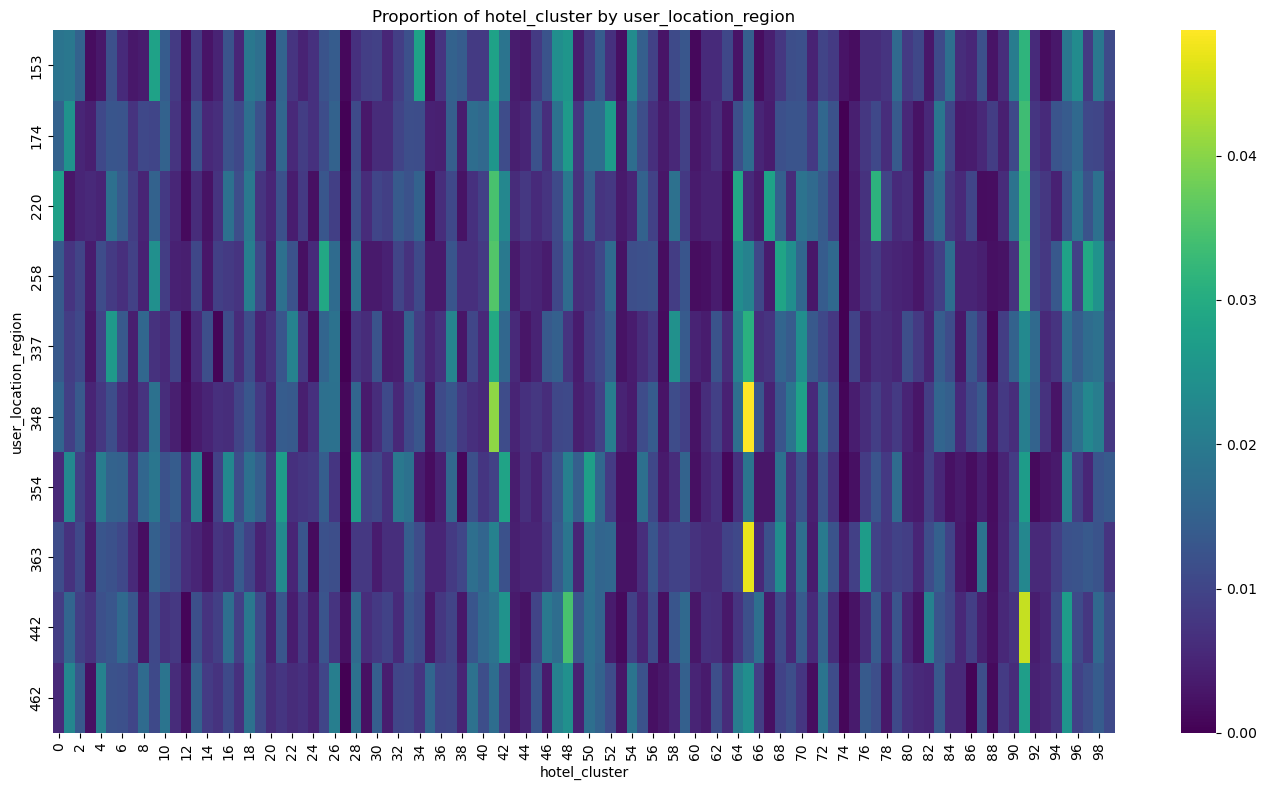

153: [(91, 61), (9, 54), (34, 54)]
174: [(91, 421), (52, 331), (48, 330)]
220: [(41, 149), (91, 140), (77, 135)]
258: [(41, 86), (91, 81), (25, 71)]
337: [(65, 67), (41, 64), (5, 57)]
...

Analyzing user_location_city:
user_location_city has 3751 unique values. Analyzing top 10 most common values.


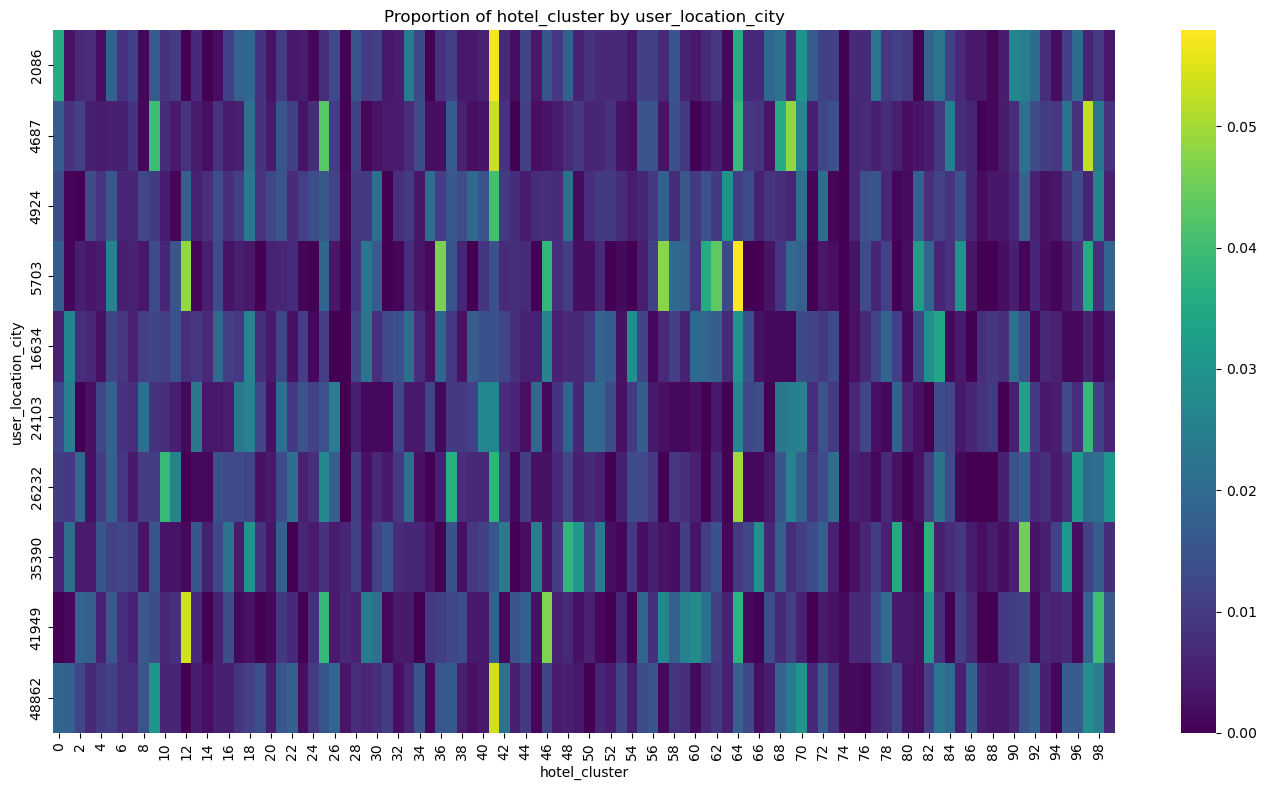

2086: [(41, 63), (0, 39), (64, 39)]
4687: [(41, 52), (97, 51), (69, 47)]
4924: [(41, 46), (63, 33), (98, 30)]
5703: [(64, 85), (12, 71), (57, 70)]
16634: [(83, 26), (64, 23), (54, 22)]
...

Analyzing is_mobile:


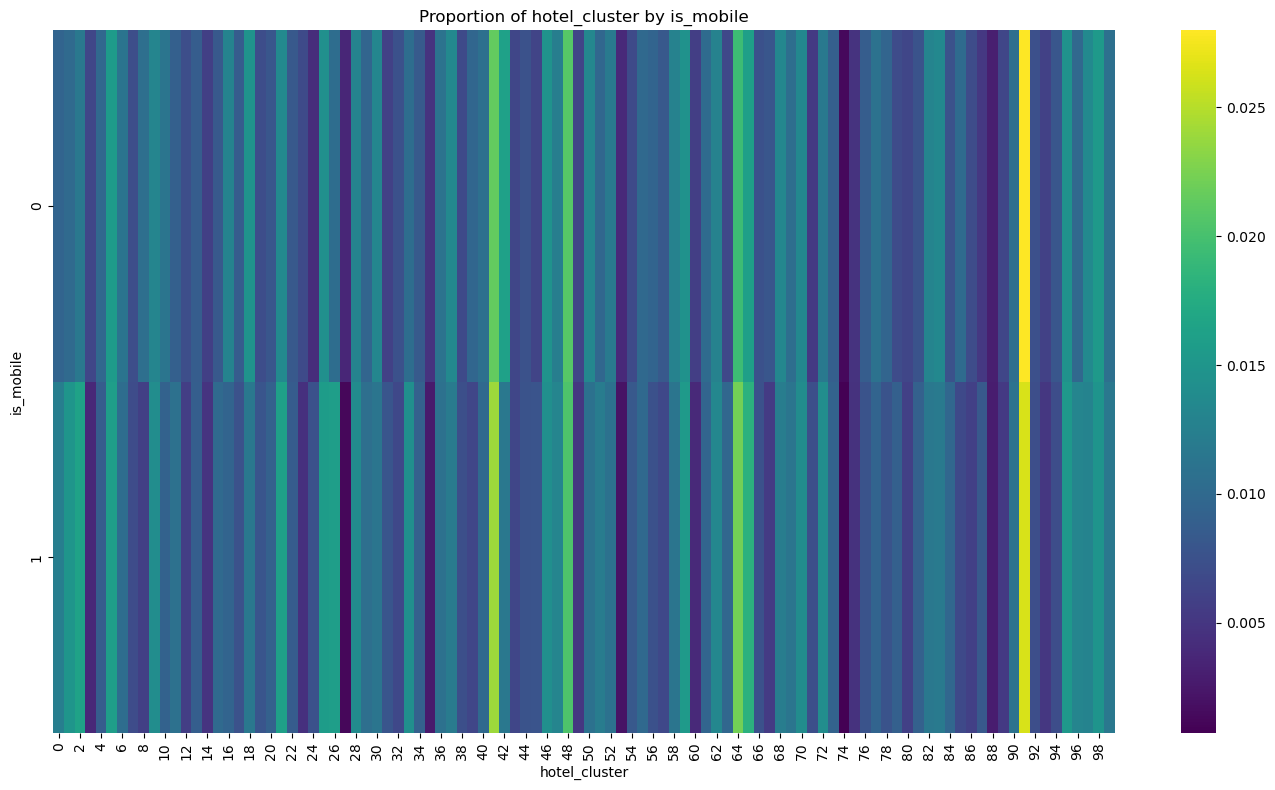

0: [(91, 2413), (41, 1845), (48, 1796)]
1: [(91, 364), (41, 331), (64, 307)]

Analyzing is_package:


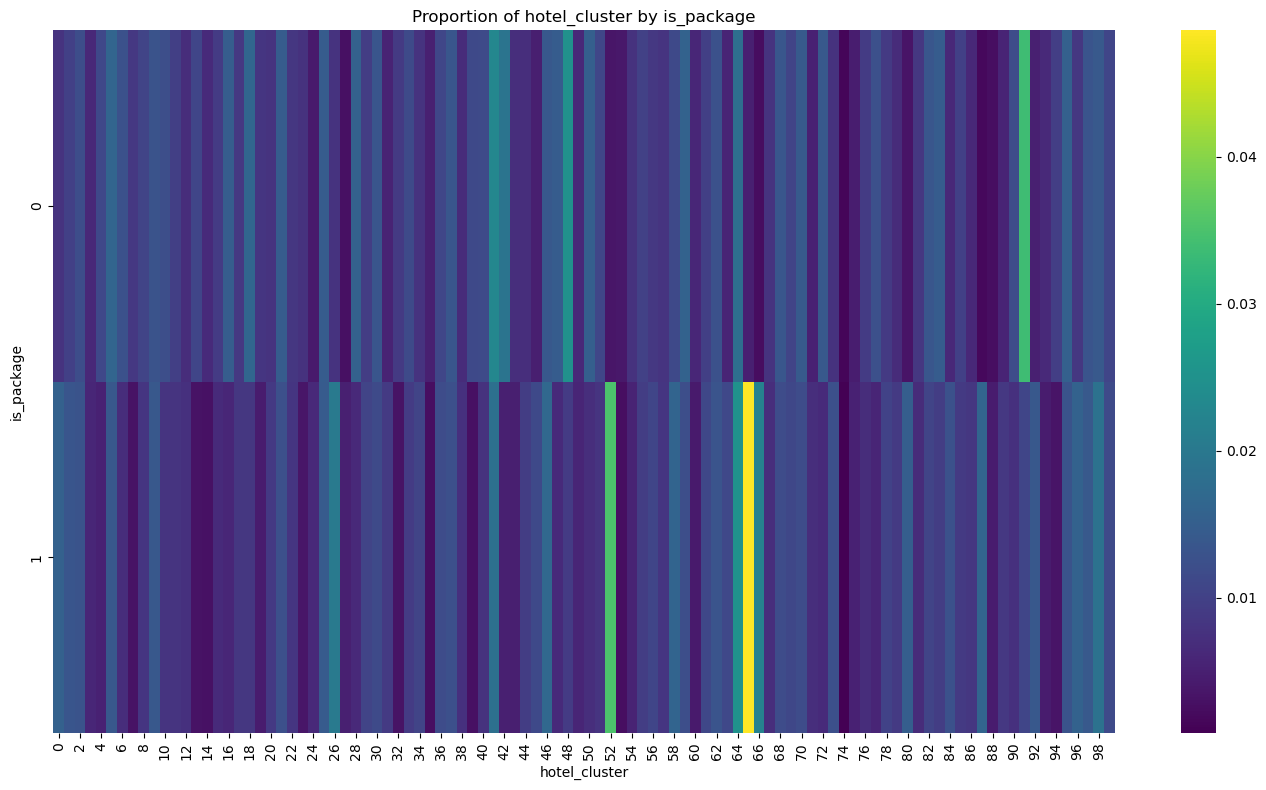

0: [(91, 2500), (48, 1838), (41, 1702)]
1: [(65, 1266), (52, 912), (64, 649)]

Analyzing channel:
channel has 11 unique values. Analyzing top 10 most common values.


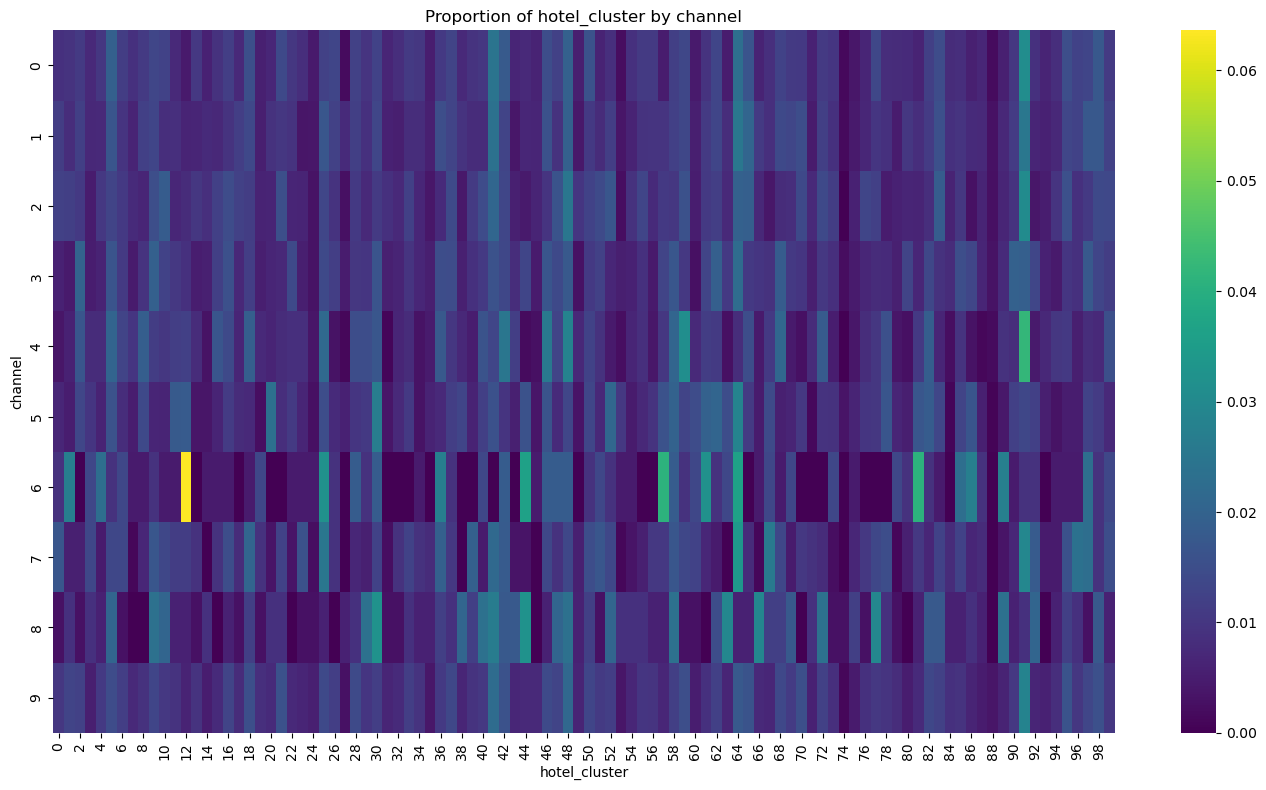

0: [(91, 412), (41, 328), (64, 307)]
1: [(91, 263), (64, 262), (41, 247)]
2: [(91, 263), (48, 215), (41, 179)]
3: [(64, 96), (2, 87), (90, 84)]
4: [(91, 108), (59, 80), (48, 73)]
...

Analyzing srch_destination_id:
srch_destination_id has 5296 unique values. Analyzing top 10 most common values.


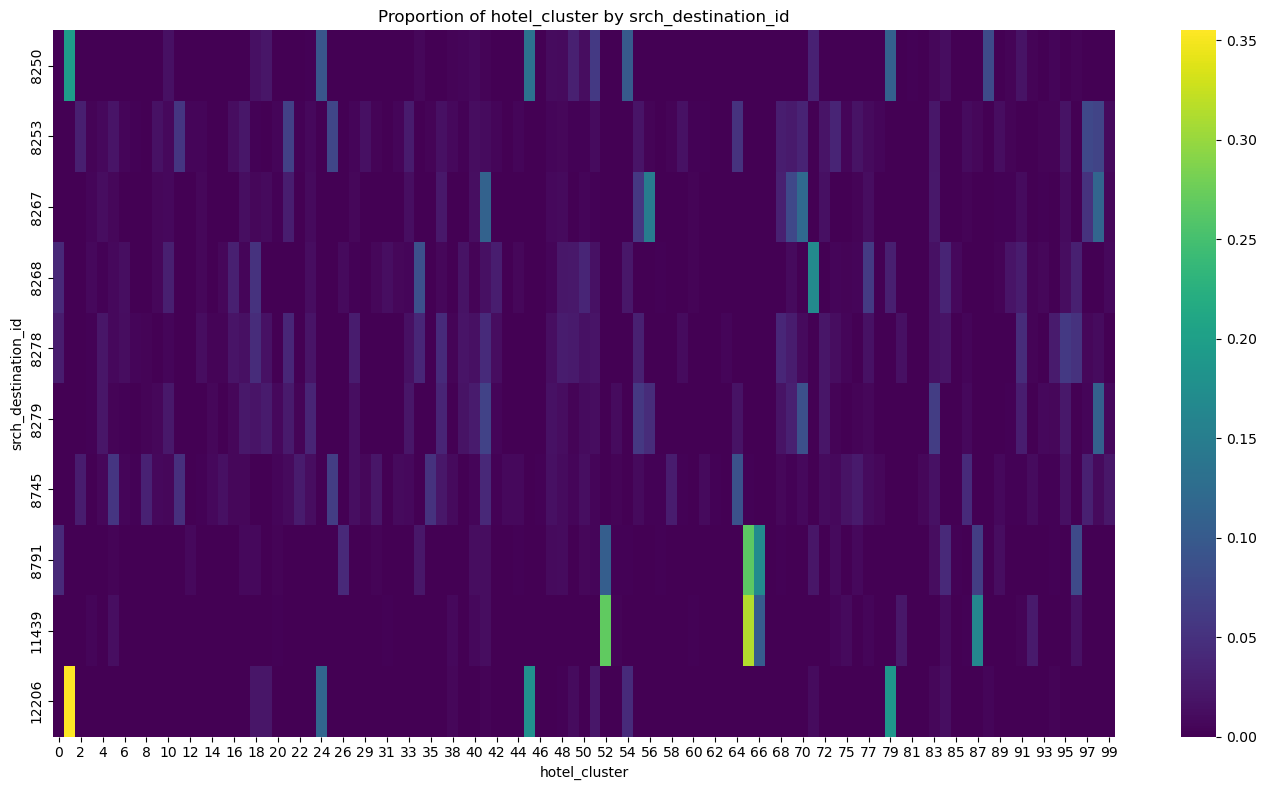

8250: [(1, 670), (45, 455), (79, 376)]
8253: [(97, 103), (25, 100), (98, 95)]
8267: [(56, 364), (70, 298), (98, 282)]
8268: [(71, 264), (34, 136), (77, 95)]
8278: [(95, 55), (96, 47), (18, 41)]
...

Analyzing srch_destination_type_id:


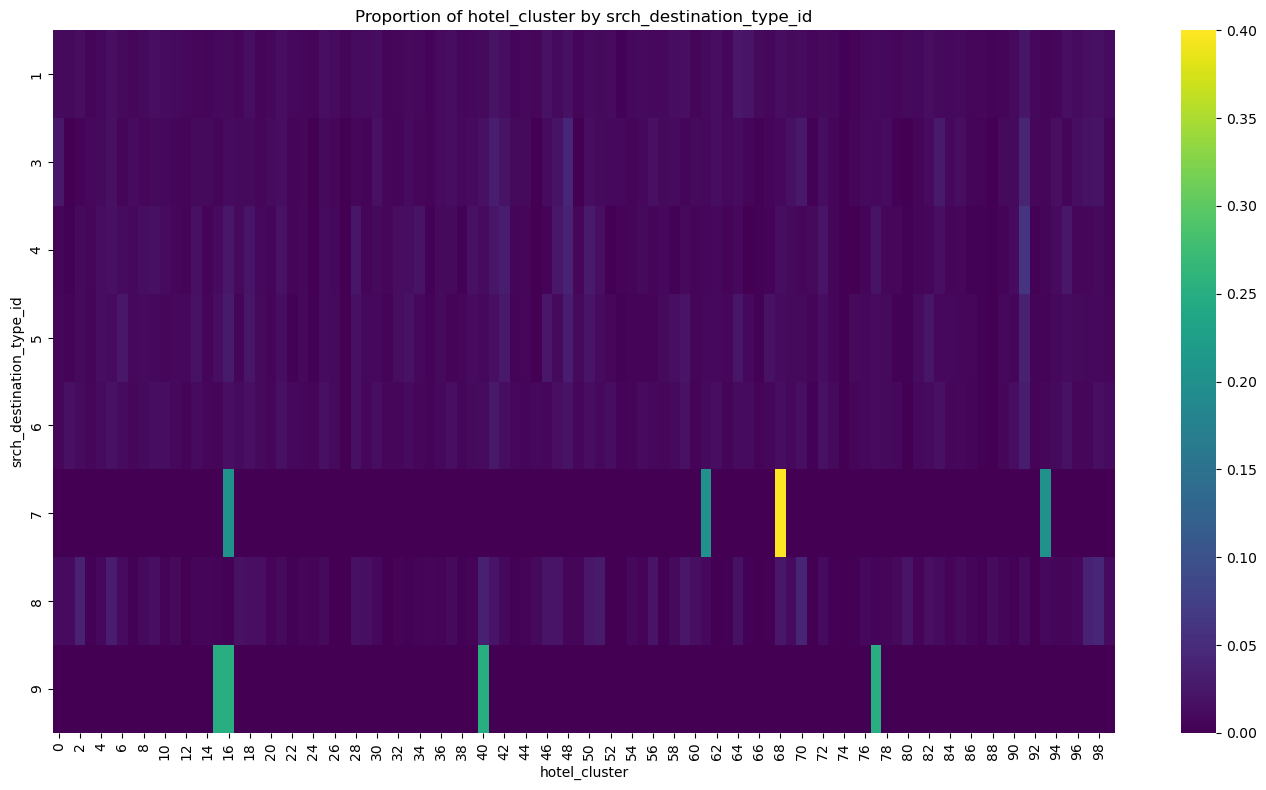

1: [(64, 1489), (91, 1430), (65, 1278)]
3: [(48, 299), (91, 284), (41, 229)]
4: [(91, 201), (48, 124), (42, 106)]
5: [(91, 190), (48, 167), (16, 142)]
6: [(91, 666), (41, 586), (48, 424)]
...

Analyzing hotel_continent:


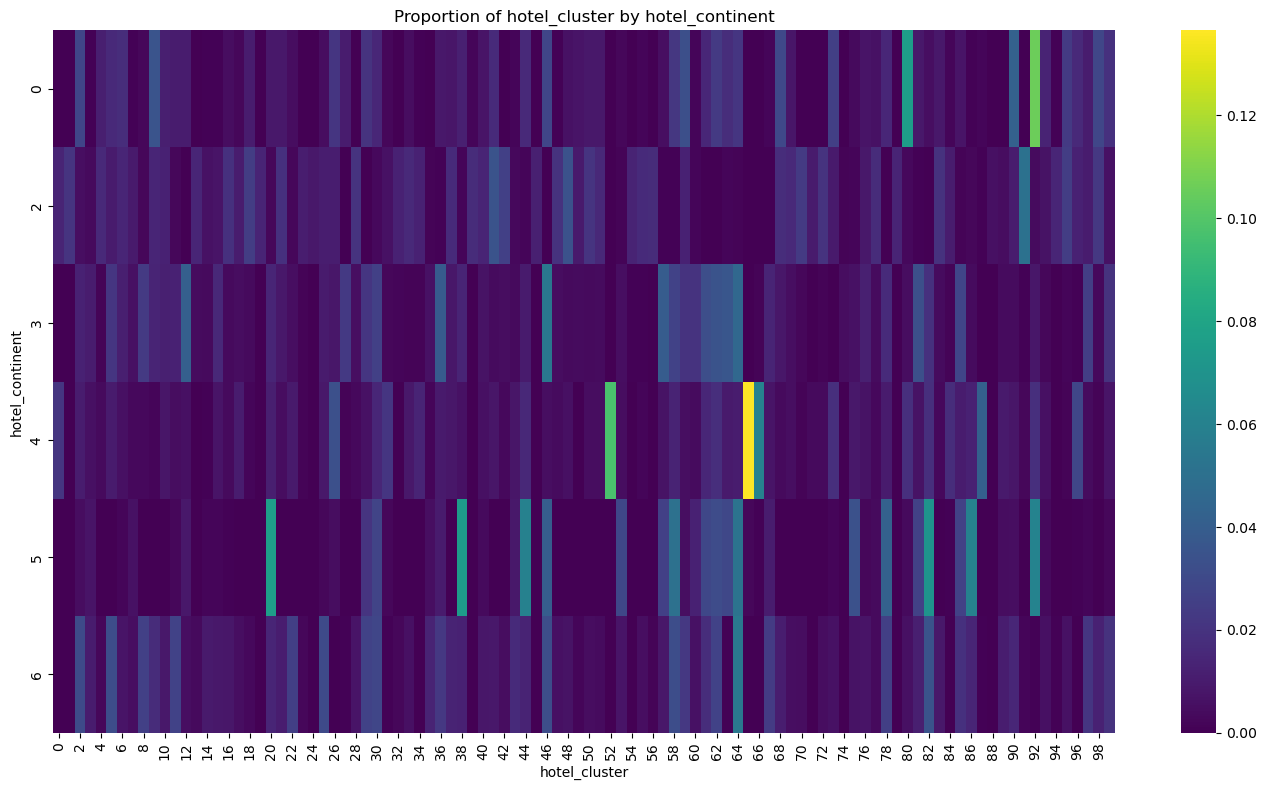

0: [(92, 122), (80, 87), (90, 48)]
2: [(91, 2696), (41, 1838), (48, 1821)]
3: [(46, 652), (64, 549), (12, 488)]
4: [(65, 1626), (52, 1160), (66, 724)]
5: [(20, 86), (38, 84), (82, 80)]
...

Analyzing hotel_country:
hotel_country has 152 unique values. Analyzing top 10 most common values.


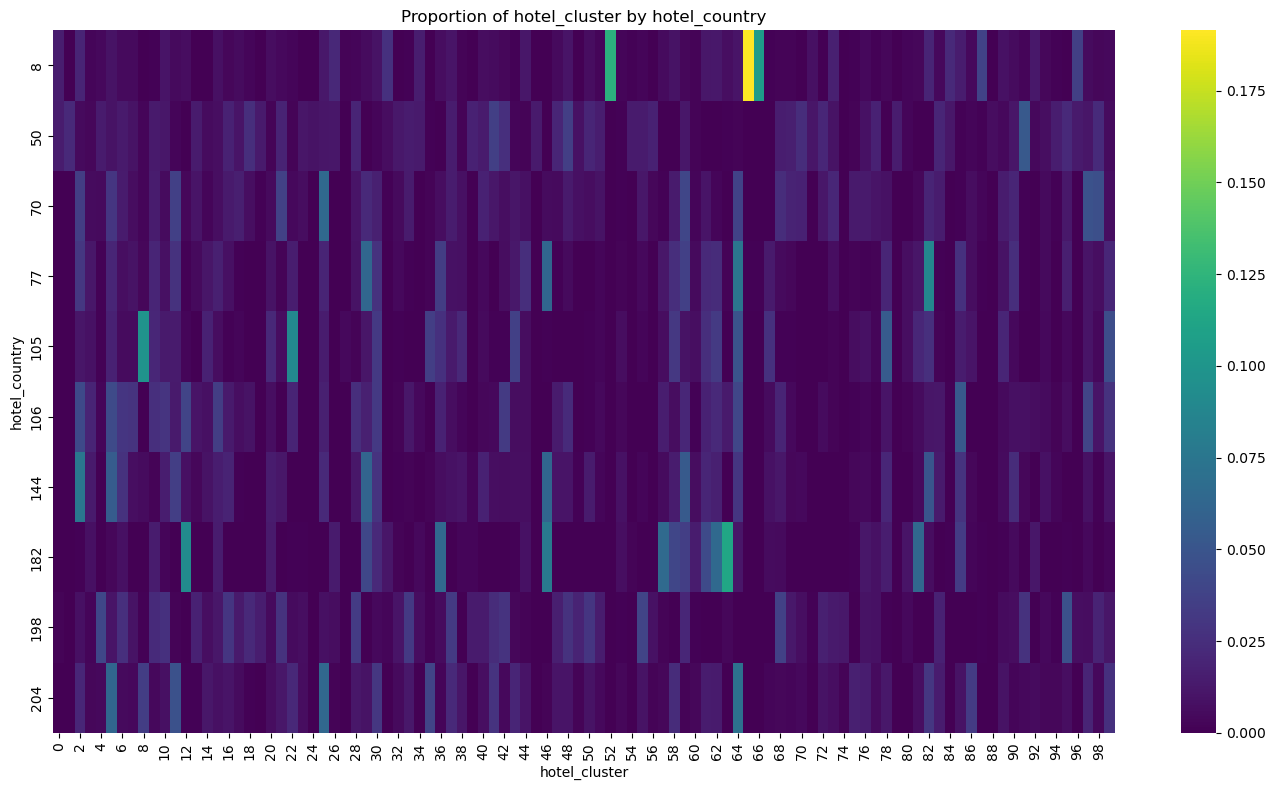

8: [(65, 964), (52, 616), (66, 529)]
50: [(91, 2582), (41, 1738), (48, 1708)]
70: [(25, 216), (97, 161), (98, 154)]
77: [(82, 205), (64, 173), (29, 147)]
105: [(8, 371), (22, 338), (78, 204)]
...

Analyzing hotel_market:
hotel_market has 1531 unique values. Analyzing top 10 most common values.


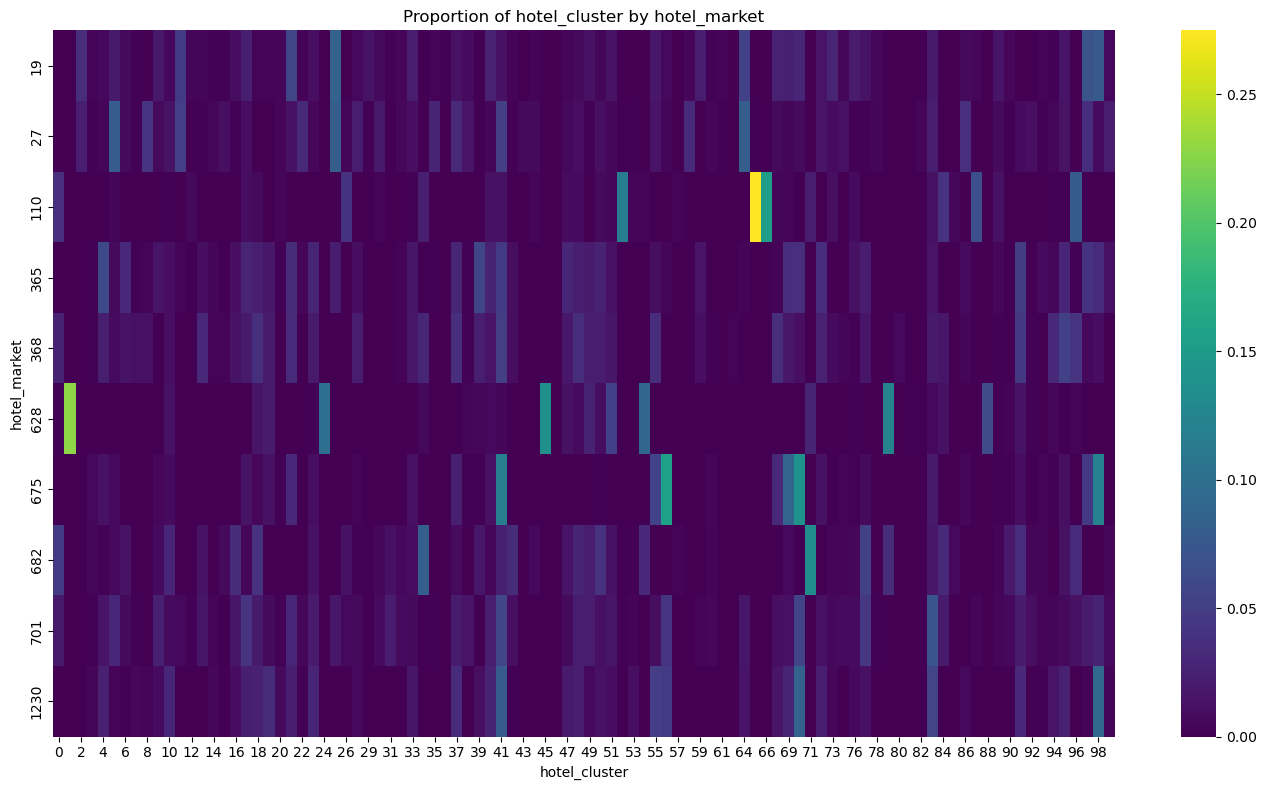

19: [(25, 172), (98, 154), (97, 143)]
27: [(25, 122), (64, 121), (5, 119)]
110: [(65, 501), (66, 276), (52, 210)]
365: [(4, 116), (39, 109), (91, 94)]
368: [(95, 83), (41, 80), (91, 71)]
...


In [23]:
# For categorical features from your dataset
categorical_features = ['site_name', 'posa_continent', 'user_location_country', 
                        'user_location_region', 'user_location_city', 'is_mobile', 
                        'is_package', 'channel', 'srch_destination_id', 
                        'srch_destination_type_id', 'hotel_continent', 
                        'hotel_country', 'hotel_market']

# Function to analyze categorical distribution
def analyze_categorical_distribution(feature, max_categories=10):
    # Check if feature has too many unique values
    unique_values = train_df[feature].nunique()
    
    if unique_values > max_categories:
        print(f"{feature} has {unique_values} unique values. Analyzing top {max_categories} most common values.")
        top_values = train_df[feature].value_counts().nlargest(max_categories).index
        filtered_df = train_df[train_df[feature].isin(top_values)]
    else:
        filtered_df = train_df
    
    # Get counts for each combination
    cross_tab = pd.crosstab(filtered_df[feature], filtered_df['hotel_cluster'])
    
    # Convert to proportions
    prop_table = cross_tab.div(cross_tab.sum(axis=1), axis=0)
    
    # Plot heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(prop_table, cmap='viridis')
    plt.title(f'Proportion of hotel_cluster by {feature}')
    plt.ylabel(feature)
    plt.xlabel('hotel_cluster')
    plt.tight_layout()
    plt.show()
    
    # Return top 3 hotel clusters for each category
    top_clusters = {}
    for cat in cross_tab.index:
        top_3 = cross_tab.loc[cat].nlargest(3)
        top_clusters[cat] = list(zip(top_3.index, top_3.values))
    
    return top_clusters

# Run for each categorical feature with reasonable number of categories
for feature in categorical_features:
    print(f"\nAnalyzing {feature}:")
    try:
        top_clusters = analyze_categorical_distribution(feature)
        
        # Print top 3 hotel clusters for each category (limited to 5 categories for readability)
        for i, (cat, clusters) in enumerate(top_clusters.items()):
            if i < 5:  # Show only first 5 categories
                print(f"{cat}: {clusters}")
            else:
                if i == 5:
                    print("...")
                break
    except Exception as e:
        print(f"Error analyzing {feature}: {e}")

In [24]:
# Function to perform chi-square test
def chi_square_test(feature, target='hotel_cluster', max_categories=30):
    # Check if feature has too many unique values
    if train_df[feature].nunique() > max_categories:
        print(f"{feature} has too many unique values for chi-square test. Sampling top {max_categories}.")
        top_values = train_df[feature].value_counts().nlargest(max_categories).index
        filtered_df = train_df[train_df[feature].isin(top_values)]
    else:
        filtered_df = train_df
    
    # Sample if dataset is too large
    if len(filtered_df) > 50000:
        filtered_df = filtered_df.sample(50000, random_state=42)
    
    contingency_table = pd.crosstab(filtered_df[feature], filtered_df[target])
    
    # Run chi-square test
    try:
        chi2, p, dof, expected = chi2_contingency(contingency_table)
        
        print(f"Chi-square test for {feature} vs {target}:")
        print(f"Chi-square value: {chi2:.2f}")
        print(f"p-value: {p:.10f}")
        print(f"Degrees of freedom: {dof}")
        print("Is relationship significant at 0.05 level?", "Yes" if p < 0.05 else "No")
        print("-" * 50)
        
        return chi2, p, dof
    except Exception as e:
        print(f"Error in chi-square test for {feature}: {e}")
        return None, None, None

# Run chi-square tests for all categorical features
chi_square_results = {}
for feature in categorical_features:
    result = chi_square_test(feature)
    if result[0] is not None:
        chi_square_results[feature] = {'chi2': result[0], 'p_value': result[1], 'dof': result[2]}

# Sort features by chi-square value to identify strongest relationships
if chi_square_results:
    sorted_features = sorted(chi_square_results.items(), key=lambda x: x[1]['chi2'], reverse=True)
    print("\nCategorical features ranked by strength of relationship with hotel_cluster:")
    for feature, stats in sorted_features:
        print(f"{feature}: Chi2 = {stats['chi2']:.2f}, p = {stats['p_value']:.10f}")

site_name has too many unique values for chi-square test. Sampling top 30.
Chi-square test for site_name vs hotel_cluster:
Chi-square value: 14611.18
p-value: 0.0000000000
Degrees of freedom: 2871
Is relationship significant at 0.05 level? Yes
--------------------------------------------------
Chi-square test for posa_continent vs hotel_cluster:
Chi-square value: 7562.77
p-value: 0.0000000000
Degrees of freedom: 396
Is relationship significant at 0.05 level? Yes
--------------------------------------------------
user_location_country has too many unique values for chi-square test. Sampling top 30.
Chi-square test for user_location_country vs hotel_cluster:
Chi-square value: 21073.73
p-value: 0.0000000000
Degrees of freedom: 2871
Is relationship significant at 0.05 level? Yes
--------------------------------------------------
user_location_region has too many unique values for chi-square test. Sampling top 30.
Chi-square test for user_location_region vs hotel_cluster:
Chi-square value: 

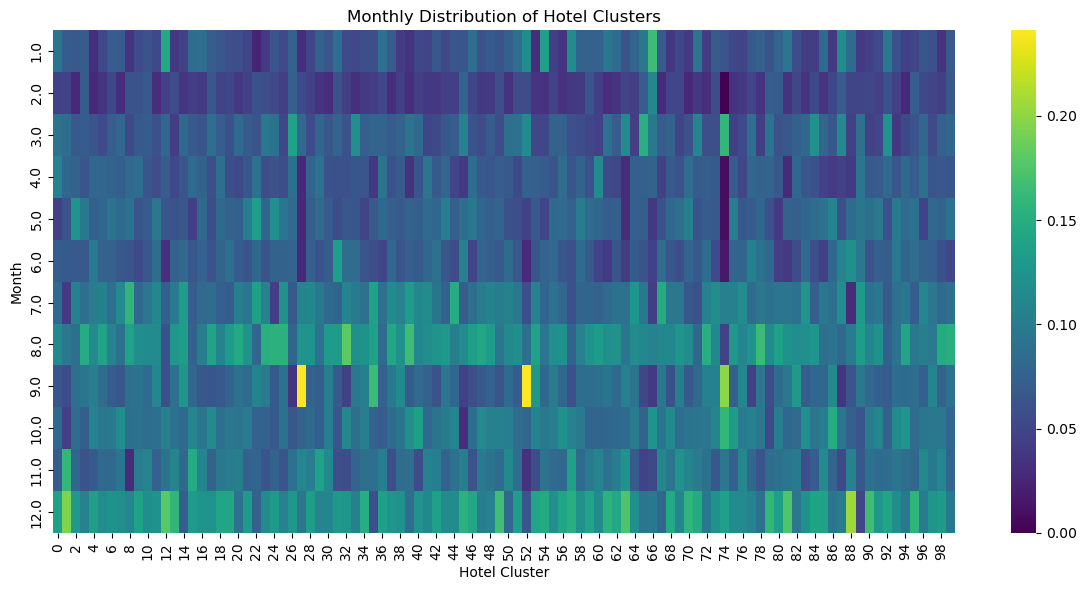

In [28]:
# Convert date strings to datetime objects
train_df['srch_ci'] = pd.to_datetime(train_df['srch_ci'], errors='coerce')
train_df['srch_co'] = pd.to_datetime(train_df['srch_co'], errors='coerce')

# Create derived features
train_df['trip_duration'] = (train_df['srch_co'] - train_df['srch_ci']).dt.days
train_df['search_month'] = train_df['srch_ci'].dt.month
train_df['search_day_of_week'] = train_df['srch_ci'].dt.dayofweek
train_df['is_weekend'] = train_df['search_day_of_week'].isin([5, 6]).astype(int)

# Analyze monthly patterns
plt.figure(figsize=(12, 6))
monthly_bookings = pd.crosstab(train_df['search_month'], train_df['hotel_cluster'])
monthly_props = monthly_bookings.div(monthly_bookings.sum(axis=0), axis=1)
sns.heatmap(monthly_props, cmap='viridis')
plt.title('Monthly Distribution of Hotel Clusters')
plt.xlabel('Hotel Cluster')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

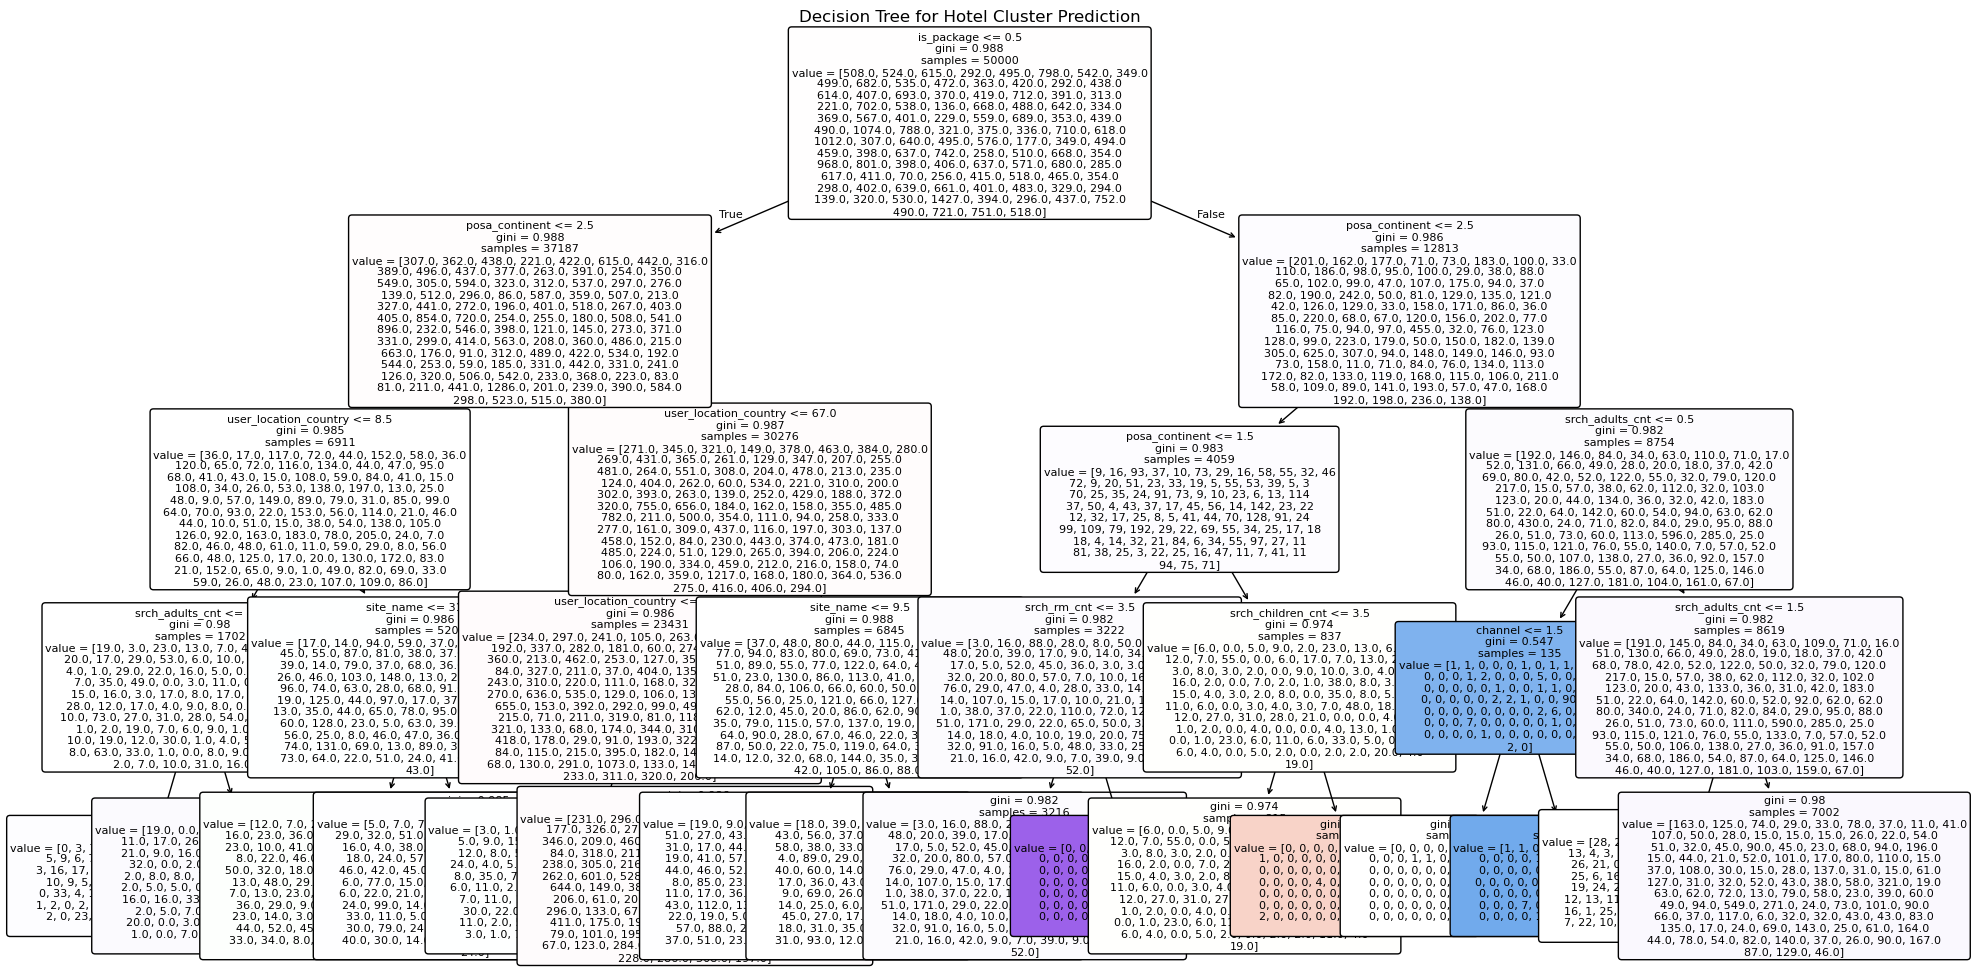

Feature importance from decision tree:
                 Feature  Importance
1         posa_continent    0.325618
6        srch_adults_cnt    0.250569
4             is_package    0.220134
2  user_location_country    0.099341
0              site_name    0.048877
5                channel    0.023610
7      srch_children_cnt    0.016765
8            srch_rm_cnt    0.015086
3              is_mobile    0.000000
9                    cnt    0.000000


In [26]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Select relevant features
features = ['site_name', 'posa_continent', 'user_location_country', 
           'is_mobile', 'is_package', 'channel', 
           'srch_adults_cnt', 'srch_children_cnt', 'srch_rm_cnt', 'cnt']

# Prepare data for decision tree
X = train_df[features].copy()
y = train_df['hotel_cluster']

# Handle missing values
X = X.fillna(-1)  # Replace NaN with -1

# Encode categorical features
for feature in X.select_dtypes(include=['object', 'category']).columns:
    le = LabelEncoder()
    X[feature] = le.fit_transform(X[feature].astype(str))

# Sample if data is too large
if len(X) > 50000:
    X, _, y, _ = train_test_split(X, y, train_size=50000, random_state=42)

# Train a simple decision tree
dt = DecisionTreeClassifier(max_depth=4, random_state=42)
dt.fit(X, y)

# Visualize the tree
plt.figure(figsize=(20, 10))
plot_tree(dt, feature_names=X.columns, filled=True, rounded=True, fontsize=8)
plt.title("Decision Tree for Hotel Cluster Prediction")
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': dt.feature_importances_
}).sort_values('Importance', ascending=False)

print("Feature importance from decision tree:")
print(feature_importance)